# import libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# data pre-processing

* Date: 日期，即交易发生的日期。
* Open: 开盘价，即当天股票交易开始时的价格。
* High: 最高价，即当天股票交易中所达到的最高价格。
* Low: 最低价，即当天股票交易中所达到的最低价格。
* Close: 收盘价，即当天股票交易结束时的价格。
* Adj Close: 调整收盘价，即在除权、除息等情况下对收盘价进行调整后的价格。
* Volume: 成交量，即当天股票交易中的总成交数量。

In [2]:
def main_script(code):

    # 获取对应股票的文件
    def get_fac2_share(code):
        tmp=pd.read_csv('01_data/trade_list/%s.csv'% (code),index_col=0,parse_dates=['date'],dtype={'code': 'str'})
        return tmp

    
    # import dataset
    seq_len = 20
    fac=get_fac2_share(code)
    fac.drop(columns='code',inplace=True)

    # 获取因子列表
    column_indices = fac.columns
    factor_idx=column_indices.drop('target2')

    # Plot raw data

    def plot_raw_data(data):
        # transform date format:from str to time
    #     data['Date'] = pd.to_datetime(data['Date'])

        fig, ax = plt.subplots(figsize=(20,10))

        # plot stock history data
        ax.plot(data.index, data['open'], color='b', label='Open')
        ax.plot(data.index, data['high'], color='g', label='High')
        ax.plot(data.index, data['low'], color='m', label='Low')
        ax.plot(data.index, data['close'], color='y', label='Close')

        # format x axis
        ax.xaxis.set_major_locator(mdates.YearLocator()) 
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 

        plt.title('Historical Stock Data %s'%(code), fontsize=26)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.xlabel("date", fontsize = 22)
        plt.ylabel("prices", fontsize = 22)
        plt.grid(True)
        plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))
        plt.savefig('03_output/pic/Historical Stock all-4 %s.png'%(code))
        plt.show()

    plot_raw_data(fac)

    train_set = fac.loc['2011-01-11':'2023-05-31', factor_idx]

    # feature scaling
    price_columns = ['open', 'close', 'high', 'low']
    sc1 = MinMaxScaler(feature_range=(0, 1))
    sc2 = MinMaxScaler(feature_range=(0, 1))
    train_set_scaled1 = sc1.fit_transform(train_set[price_columns])
    train_set_scaled2 = sc2.fit_transform(train_set[factor_idx.drop(price_columns)])
    train_set_scaled = np.concatenate((train_set_scaled1,train_set_scaled2),axis=1)
    x_train_set_scaled_df = pd.DataFrame(train_set_scaled, columns=factor_idx)

    y_train = x_train_set_scaled_df.iloc[seq_len:, 0:4].values

    # function to reshape features into seq_array: (samples, time steps, features)
    def gen_sequence(df, seq_length, seq_cols):
        data_array = df[seq_cols].values
        num_elements = data_array.shape[0]
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_array[start:stop, :]

    # pick the feature columns
    # sequence_cols = ['open', 'close', 'high', 'low']

    # generator for the training sequences
    x_seq_gen = (list(gen_sequence(x_train_set_scaled_df, seq_len, factor_idx)))

    # generate sequences and convert to numpy array
    x_train = np.stack(list(x_seq_gen)).astype(np.float32)

    # define an object (initializing LSTM)
    model = tf.keras.Sequential()

    # first LSTM layer
    model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, input_shape=(seq_len, len(factor_idx))))
    # dropout layer
    model.add(tf.keras.layers.Dropout(0.2))
    # second LSTM layer
    model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
    # dropout layer
    model.add(tf.keras.layers.Dropout(0.2))
    # third LSTM layer
    model.add(tf.keras.layers.LSTM(units=80, return_sequences=True))
    # dropout layer
    model.add(tf.keras.layers.Dropout(0.2))
    # fourth LSTM layer
    model.add(tf.keras.layers.LSTM(units=128))
    # dropout layer
    model.add(tf.keras.layers.Dropout(0.2))
    # output layer
    model.add(tf.keras.layers.Dense(units=4, activation='sigmoid'))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.summary()
    
    # train the model
    model.fit(x_train, y_train, batch_size=32, epochs=150, validation_split=0.1, verbose=1)

    model.save('02_model/lstm all-4 %s.h5'%(code))

    # make predictions
    test_data = fac.loc['2023-06-01':'2024-05-29']
    real_stock_price = fac.loc['2023-06-01':'2024-05-29', factor_idx]
    # get predicted stock prices of month Dec 2023
    # concatination
    dataset_total = fac.loc[:, factor_idx]
    # stock prices of previous 30 days for each day of Nov 2023
    inputs = dataset_total[len(dataset_total) - len(test_data) - 20:]
    test_set_scaled1 = sc1.fit_transform(inputs[price_columns])
    test_set_scaled2 = sc2.fit_transform(inputs[factor_idx.drop(price_columns)])
    test_set_scaled = np.concatenate((test_set_scaled1,test_set_scaled2),axis=1)
    x_test_set_scaled_df = pd.DataFrame(test_set_scaled, columns=factor_idx)

    # generator for the training sequences
    x_seq_gen_test = (list(gen_sequence(x_test_set_scaled_df, seq_len, factor_idx)))

    # generate sequences and convert to numpy array
    x_test = np.stack(list(x_seq_gen_test)).astype(np.float32)

    # get predicted stock prices
    predicted_stock_price = model.predict(x_test)
    predicted_stock_price = sc1.inverse_transform(predicted_stock_price)
    predicted_stock_price = pd.DataFrame(predicted_stock_price, columns=price_columns)

    predicted_stock_price.index=test_data.index
    predicted_stock_price.to_csv('03_output/csv/pre all-4 %s.csv'%(code))

    # visualization

    fig = plt.figure(figsize=(20,16))
    # transform date format:from str to time
    # test_data['Date'] = pd.to_datetime(test_data['Date'])
    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(test_data.index, real_stock_price[price_columns[i-1]], color='b', label=price_columns[i-1])
        plt.plot(test_data.index, predicted_stock_price[price_columns[i-1]], color='g', label=price_columns[i-1]+'_predicted')
        plt.title('Predicted Stock Data %s'%(code), fontsize=26)
        plt.xlabel("date", fontsize = 22)
        plt.ylabel("prices", fontsize = 22)
        plt.grid(True)
        plt.legend(fontsize = 16)

    plt.savefig('03_output/pic/predicted all-4 %s.png'%(code))

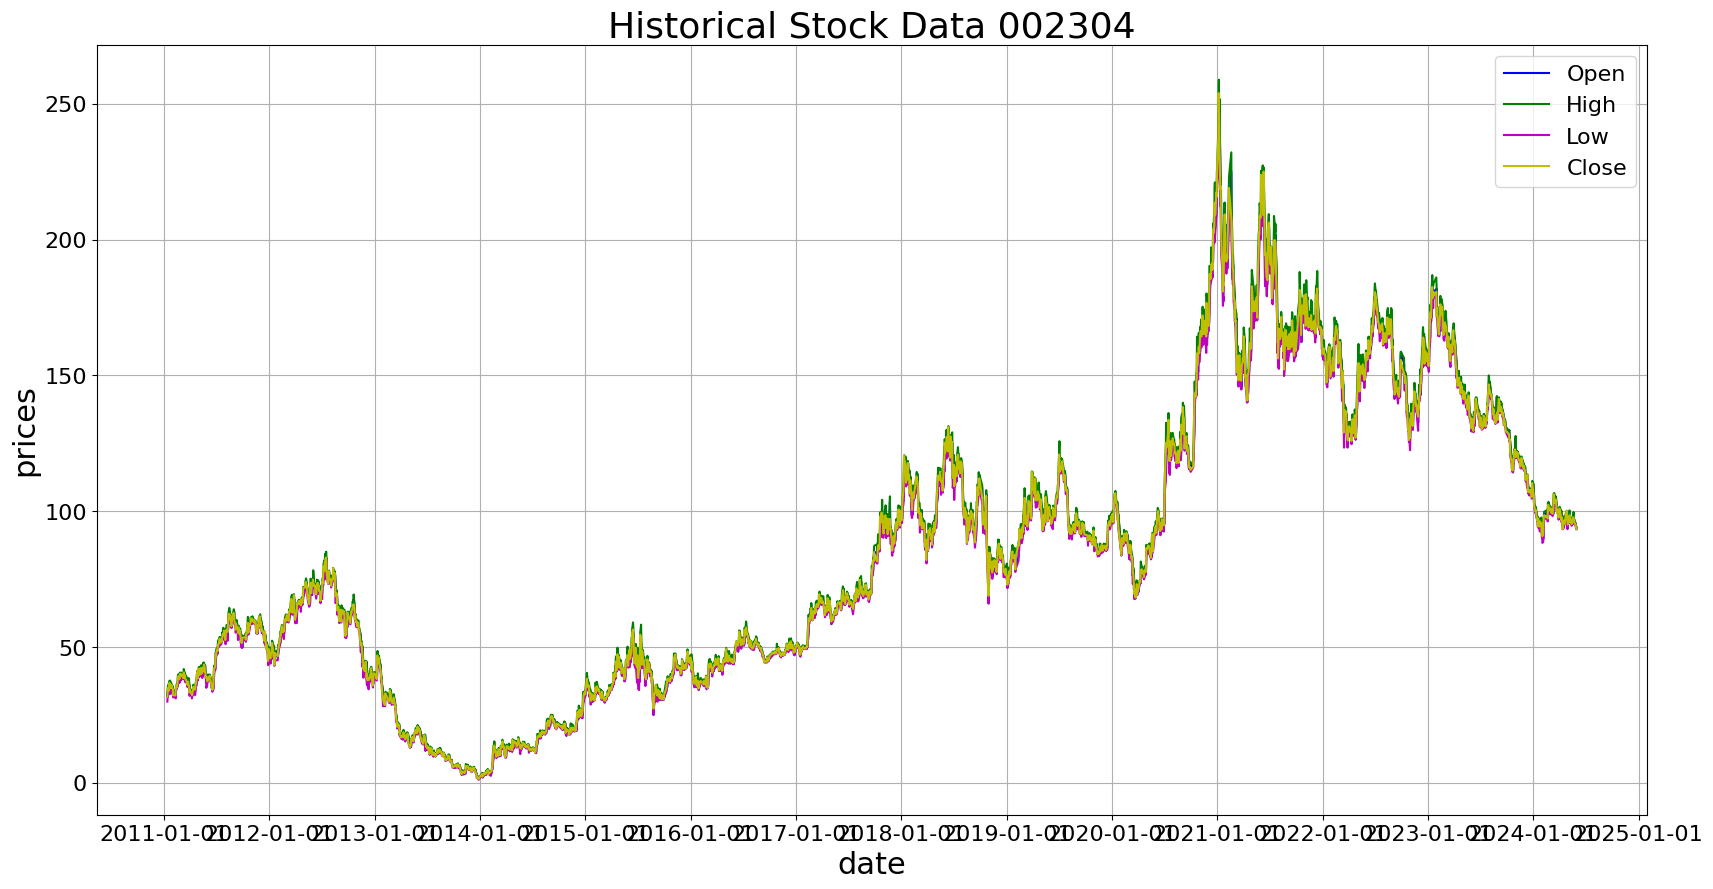

2024-06-06 21:54:39.159245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 21:54:39.167611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 21:54:39.168270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 21:54:39.170198: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            24832     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 80)            46400     
                                                                 
 dropout_2 (Dropout)         (None, 20, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               1

2024-06-06 21:54:43.431079: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


 1/83 [..............................] - ETA: 5:10 - loss: 0.0935

2024-06-06 21:54:44.018513: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


83/83 [==============================] - 6s 22ms/step - loss: 0.0120 - val_loss: 0.0033
Epoch 2/150
83/83 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/150
83/83 [==============================] - 1s 15ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 4/150
83/83 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/150
83/83 [==============================] - 1s 15ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 6/150
83/83 [==============================] - 1s 15ms/step - loss: 0.0011 - val_loss: 9.0754e-04
Epoch 7/150
83/83 [==============================] - 1s 15ms/step - loss: 8.9474e-04 - val_loss: 7.7084e-04
Epoch 8/150
83/83 [==============================] - 1s 15ms/step - loss: 8.5947e-04 - val_loss: 8.1470e-04
Epoch 9/150
83/83 [==============================] - 1s 15ms/step - loss: 8.3721e-04 - val_loss: 0.0013
Epoch 10/150
83/83 [==============================] - 1s 16ms/step - loss: 8.4312e-04 - 

Epoch 77/150
83/83 [==============================] - 1s 17ms/step - loss: 2.7840e-04 - val_loss: 1.6669e-04
Epoch 78/150
83/83 [==============================] - 1s 17ms/step - loss: 2.6122e-04 - val_loss: 1.5978e-04
Epoch 79/150
83/83 [==============================] - 1s 16ms/step - loss: 2.5570e-04 - val_loss: 2.0743e-04
Epoch 80/150
83/83 [==============================] - 1s 16ms/step - loss: 2.6844e-04 - val_loss: 2.2481e-04
Epoch 81/150
83/83 [==============================] - 1s 15ms/step - loss: 2.5011e-04 - val_loss: 2.4318e-04
Epoch 82/150
83/83 [==============================] - 1s 16ms/step - loss: 2.6654e-04 - val_loss: 2.9417e-04
Epoch 83/150
83/83 [==============================] - 1s 16ms/step - loss: 2.4656e-04 - val_loss: 2.8359e-04
Epoch 84/150
83/83 [==============================] - 1s 15ms/step - loss: 2.9363e-04 - val_loss: 2.7890e-04
Epoch 85/150
83/83 [==============================] - 1s 16ms/step - loss: 2.5881e-04 - val_loss: 5.3172e-04
Epoch 86/150
83/83 

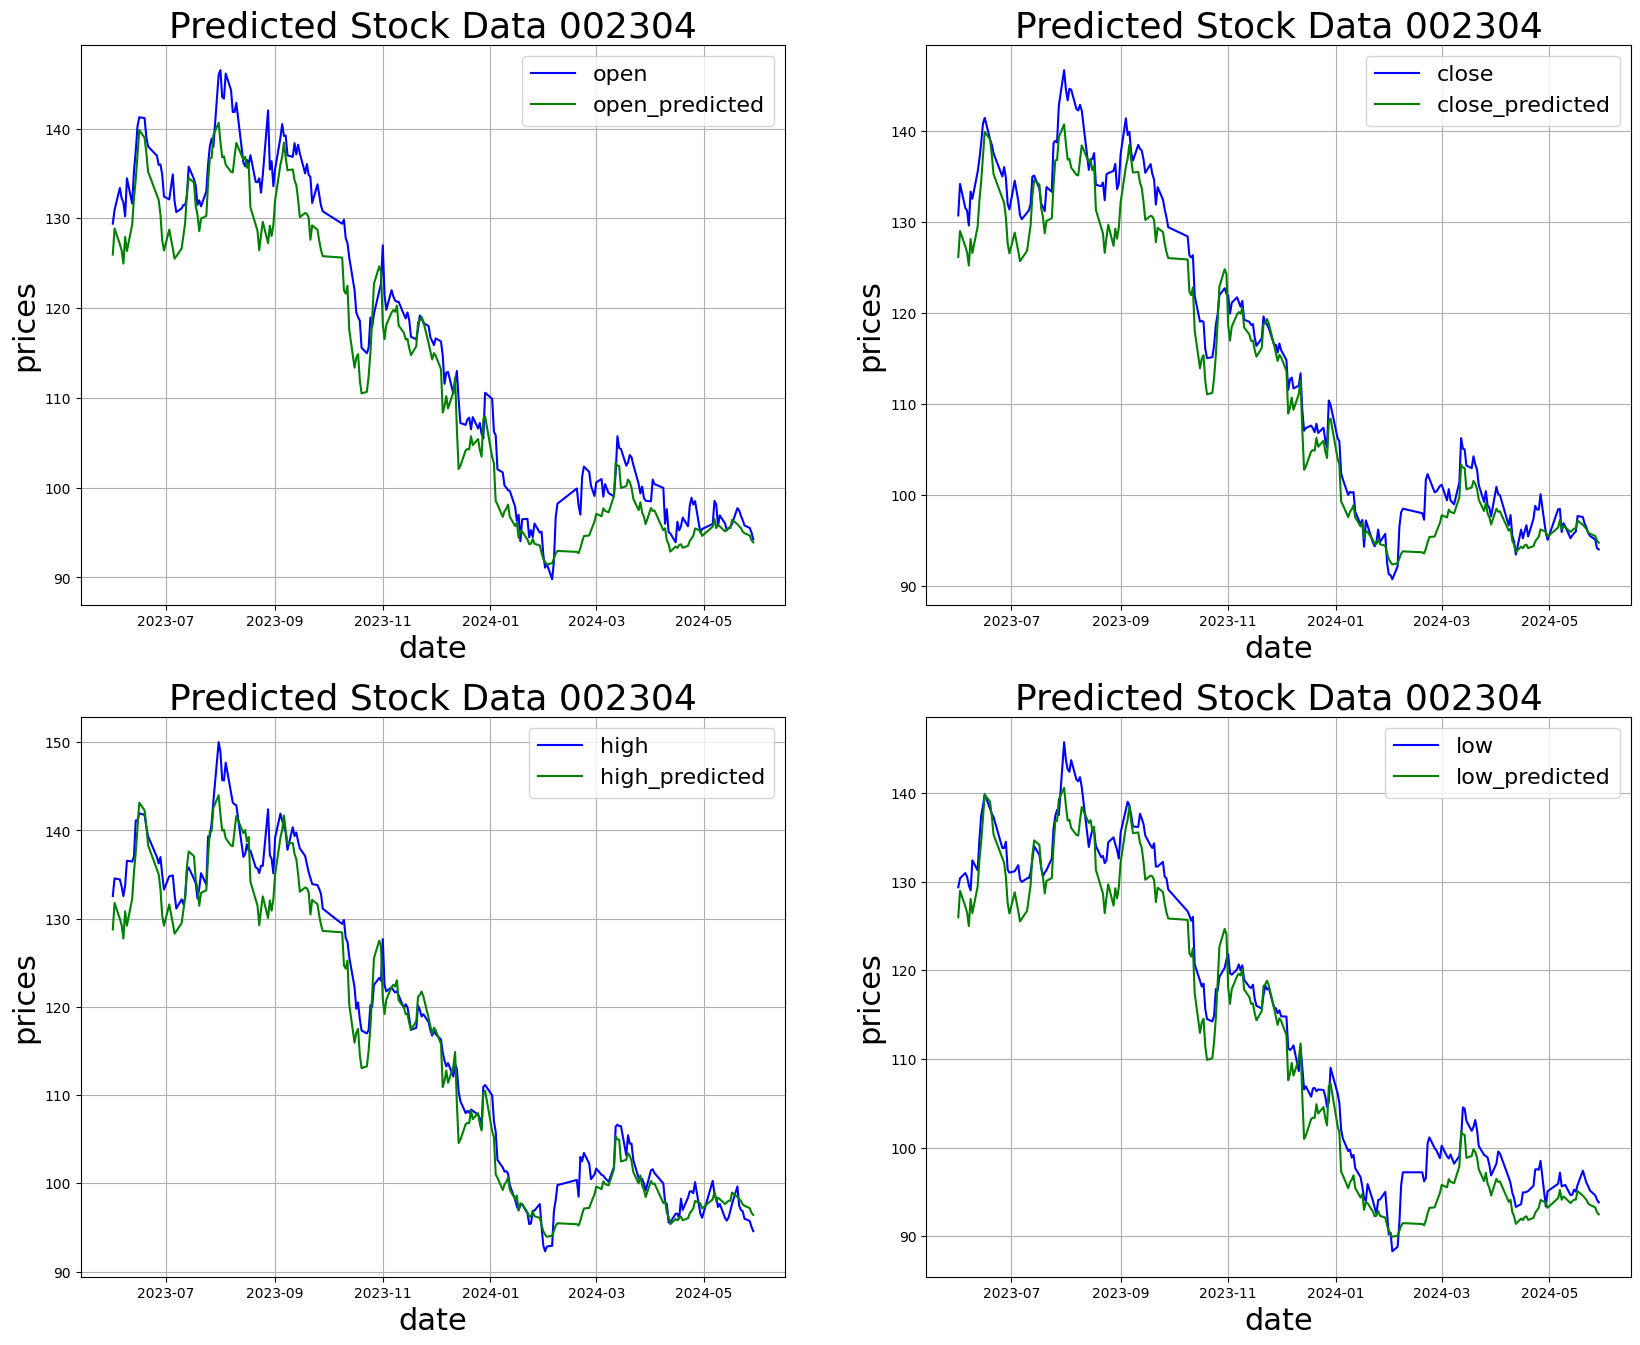

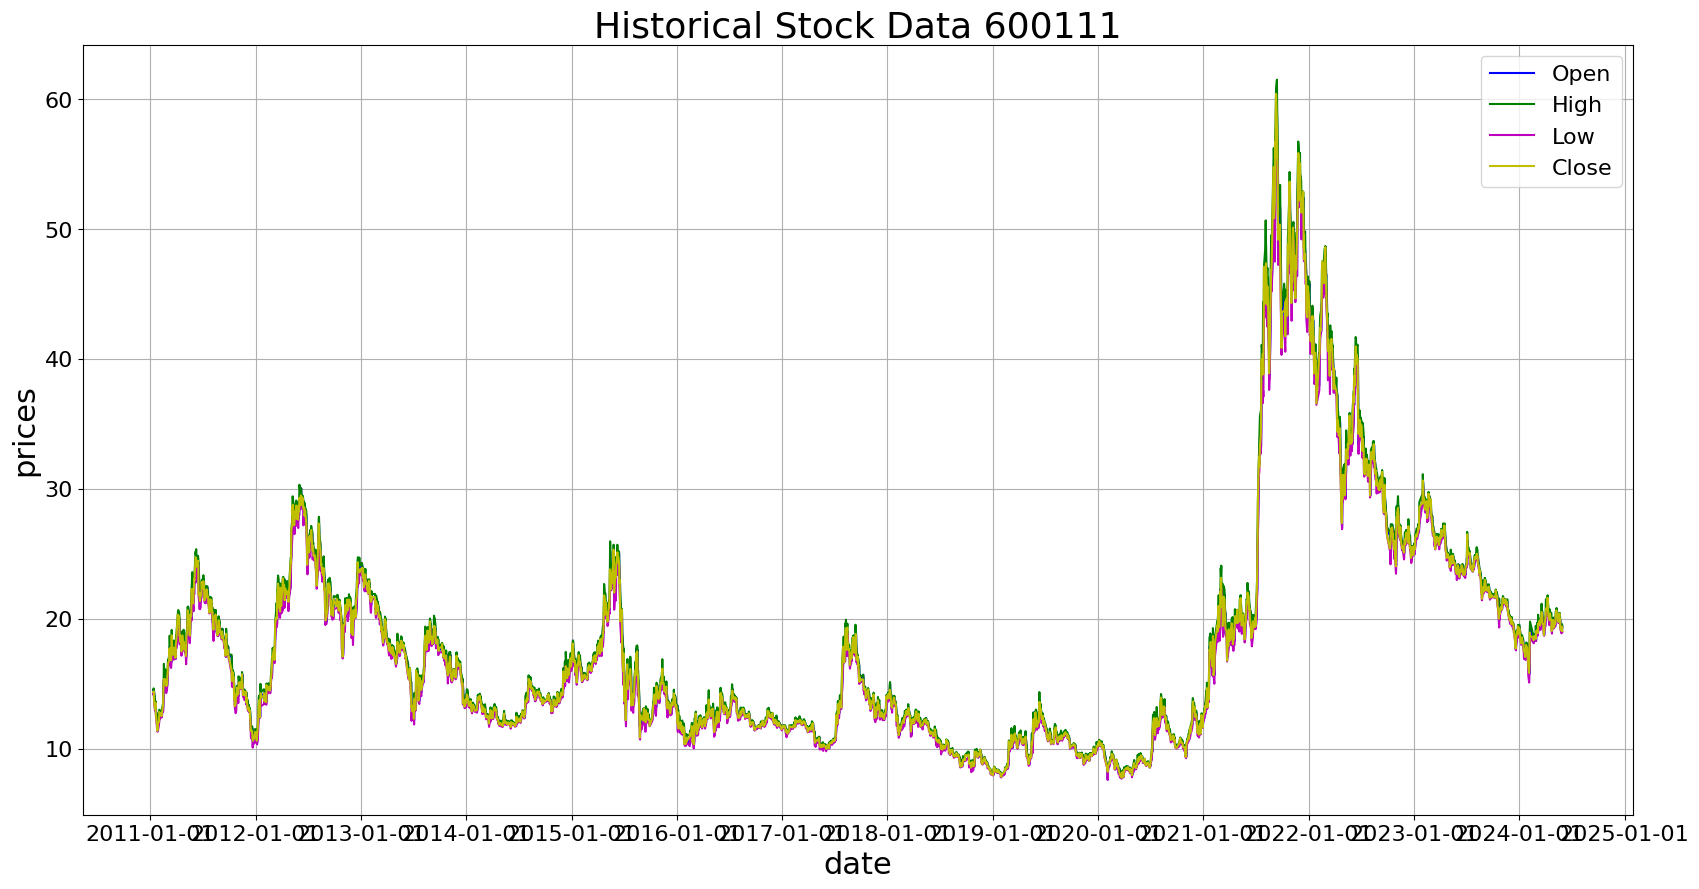

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 64)            24832     
                                                                 
 dropout_4 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20, 64)            33024     
                                                                 
 dropout_5 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 20, 80)            46400     
                                                                 
 dropout_6 (Dropout)         (None, 20, 80)            0         
                                                                 
 lstm_7 (LSTM)               (None, 128)              

Epoch 63/150
84/84 [==============================] - 1s 16ms/step - loss: 2.2204e-04 - val_loss: 9.3869e-04
Epoch 64/150
84/84 [==============================] - 1s 16ms/step - loss: 2.5010e-04 - val_loss: 8.5216e-04
Epoch 65/150
84/84 [==============================] - 1s 15ms/step - loss: 2.6164e-04 - val_loss: 6.8143e-04
Epoch 66/150
84/84 [==============================] - 1s 15ms/step - loss: 3.0864e-04 - val_loss: 0.0026
Epoch 67/150
84/84 [==============================] - 1s 15ms/step - loss: 2.6760e-04 - val_loss: 0.0012
Epoch 68/150
84/84 [==============================] - 1s 15ms/step - loss: 2.6023e-04 - val_loss: 0.0021
Epoch 69/150
84/84 [==============================] - 1s 15ms/step - loss: 2.6097e-04 - val_loss: 0.0011
Epoch 70/150
84/84 [==============================] - 1s 15ms/step - loss: 2.1524e-04 - val_loss: 8.8079e-04
Epoch 71/150
84/84 [==============================] - 1s 15ms/step - loss: 2.7734e-04 - val_loss: 0.0015
Epoch 72/150
84/84 [===================

84/84 [==============================] - 1s 16ms/step - loss: 2.2362e-04 - val_loss: 0.0017
Epoch 140/150
84/84 [==============================] - 1s 17ms/step - loss: 1.8157e-04 - val_loss: 7.0124e-04
Epoch 141/150
84/84 [==============================] - 1s 17ms/step - loss: 1.8807e-04 - val_loss: 0.0018
Epoch 142/150
84/84 [==============================] - 1s 16ms/step - loss: 1.9731e-04 - val_loss: 0.0024
Epoch 143/150
84/84 [==============================] - 1s 16ms/step - loss: 1.8491e-04 - val_loss: 0.0010
Epoch 144/150
84/84 [==============================] - 1s 15ms/step - loss: 2.1868e-04 - val_loss: 8.8738e-04
Epoch 145/150
84/84 [==============================] - 1s 15ms/step - loss: 2.1858e-04 - val_loss: 0.0010
Epoch 146/150
84/84 [==============================] - 1s 16ms/step - loss: 2.0665e-04 - val_loss: 0.0020
Epoch 147/150
84/84 [==============================] - 1s 15ms/step - loss: 1.8156e-04 - val_loss: 0.0021
Epoch 148/150
84/84 [==============================]

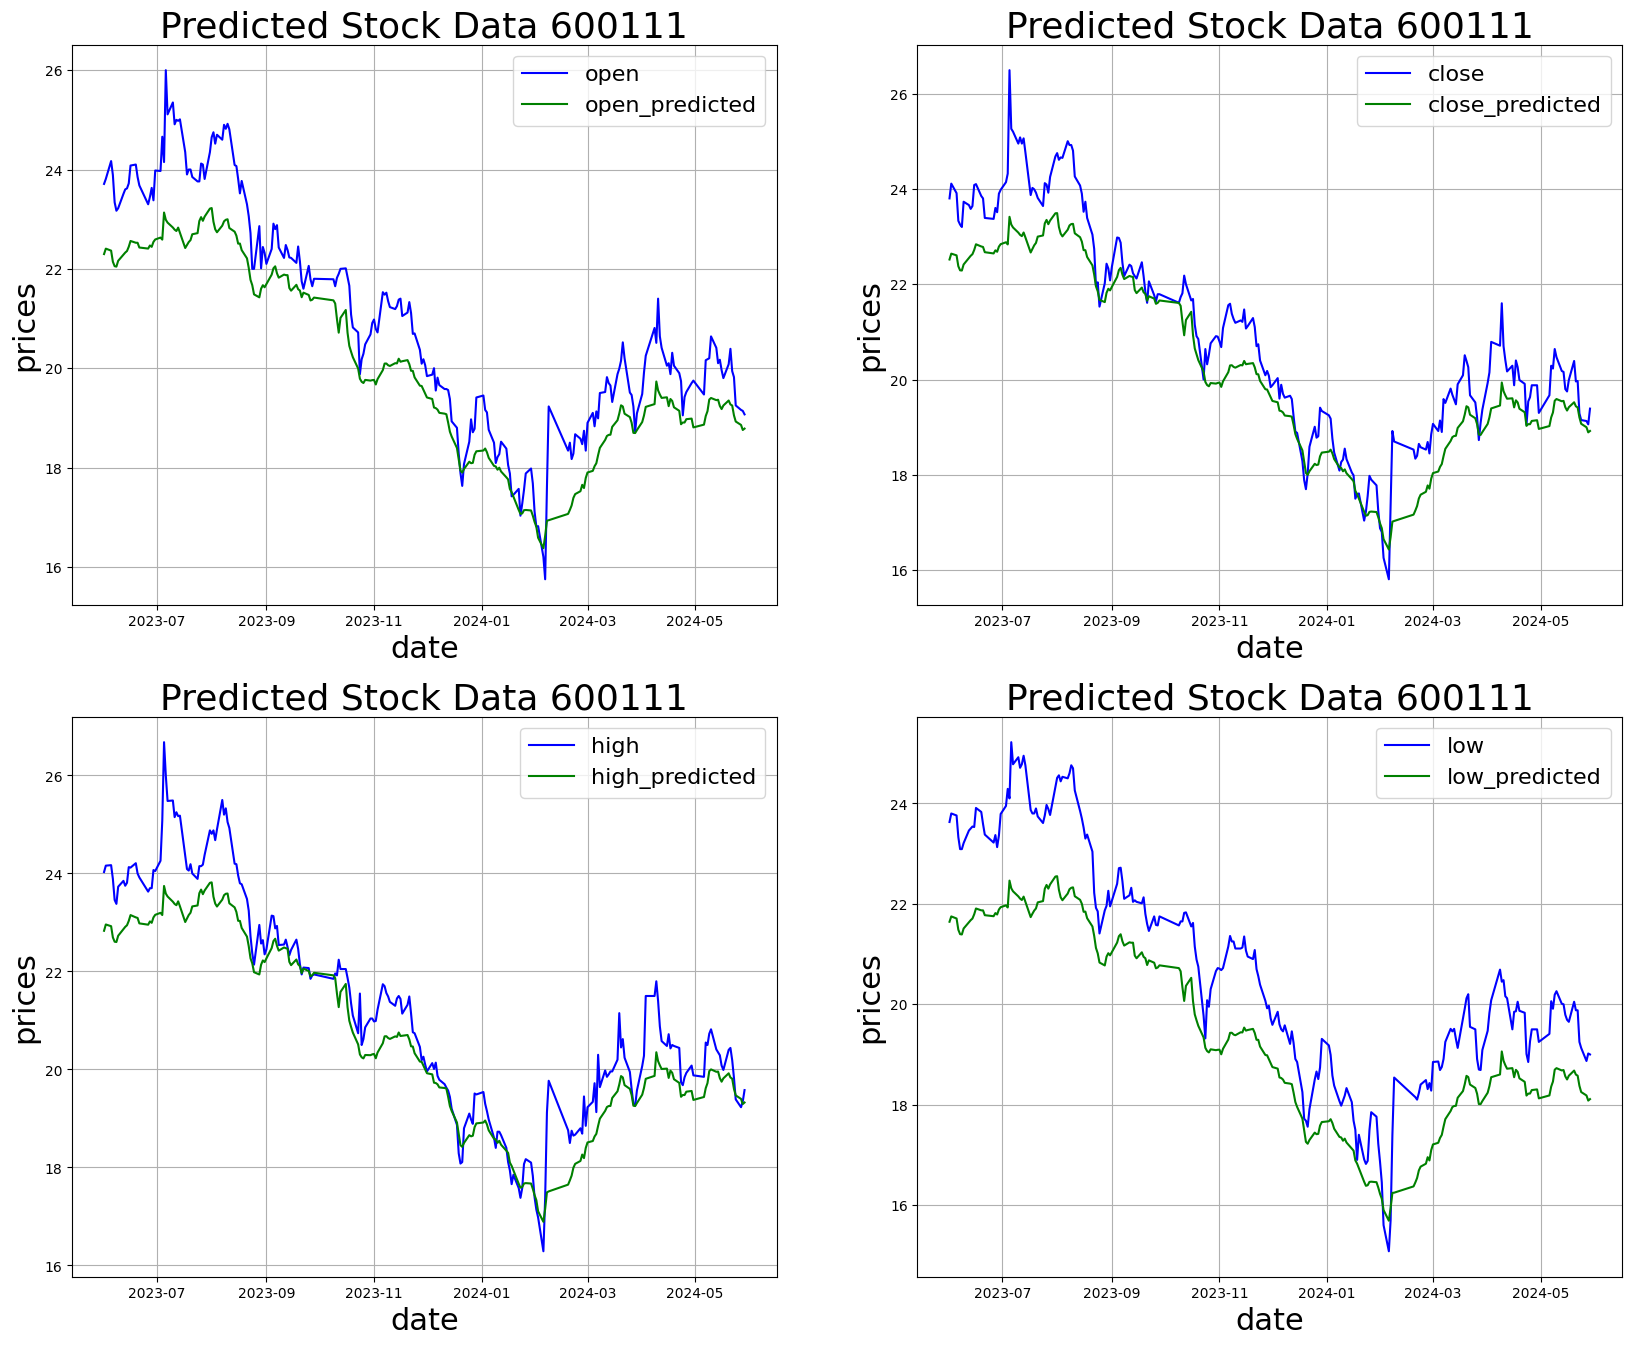

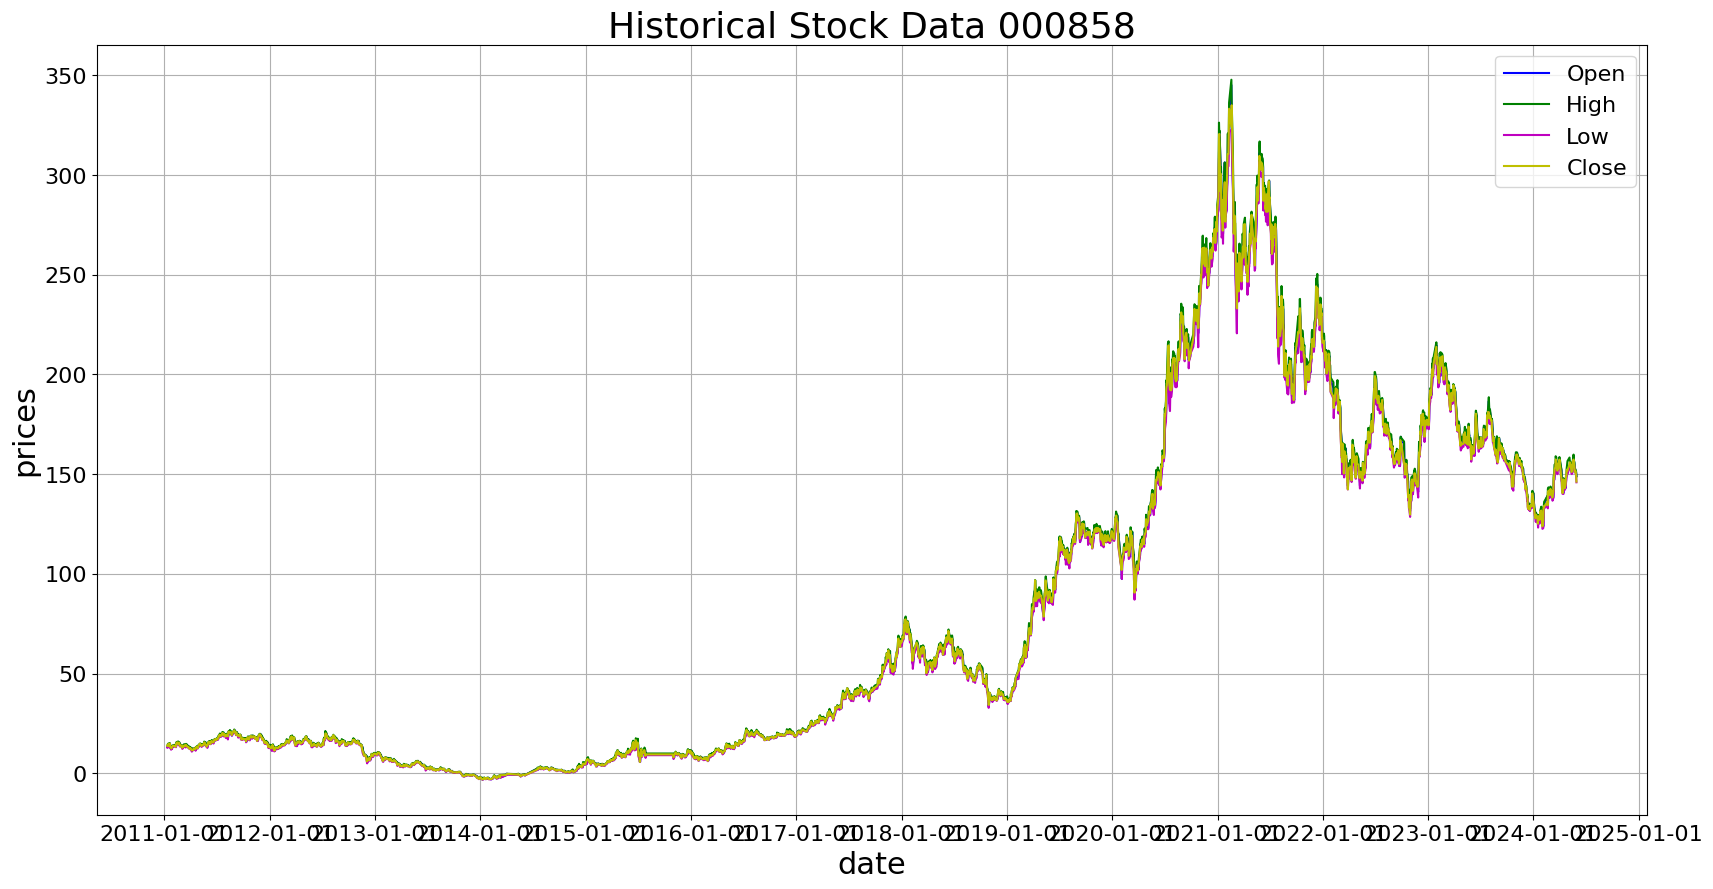

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 64)            24832     
                                                                 
 dropout_8 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 20, 64)            33024     
                                                                 
 dropout_9 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_10 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_10 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_11 (LSTM)              (None, 128)              

81/81 [==============================] - 1s 17ms/step - loss: 2.8561e-04 - val_loss: 1.6541e-04
Epoch 63/150
81/81 [==============================] - 1s 18ms/step - loss: 2.4838e-04 - val_loss: 5.8401e-04
Epoch 64/150
81/81 [==============================] - 1s 16ms/step - loss: 2.8858e-04 - val_loss: 2.1673e-04
Epoch 65/150
81/81 [==============================] - 1s 15ms/step - loss: 2.2600e-04 - val_loss: 1.2729e-04
Epoch 66/150
81/81 [==============================] - 1s 17ms/step - loss: 2.3282e-04 - val_loss: 1.5201e-04
Epoch 67/150
81/81 [==============================] - 1s 19ms/step - loss: 2.5145e-04 - val_loss: 1.2369e-04
Epoch 68/150
81/81 [==============================] - 1s 16ms/step - loss: 2.2650e-04 - val_loss: 1.6013e-04
Epoch 69/150
81/81 [==============================] - 1s 15ms/step - loss: 2.3898e-04 - val_loss: 1.3296e-04
Epoch 70/150
81/81 [==============================] - 1s 18ms/step - loss: 2.3035e-04 - val_loss: 1.6207e-04
Epoch 71/150
81/81 [============

Epoch 137/150
81/81 [==============================] - 1s 17ms/step - loss: 1.9152e-04 - val_loss: 1.4428e-04
Epoch 138/150
81/81 [==============================] - 1s 16ms/step - loss: 1.8639e-04 - val_loss: 3.1795e-04
Epoch 139/150
81/81 [==============================] - 1s 16ms/step - loss: 1.9555e-04 - val_loss: 2.9141e-04
Epoch 140/150
81/81 [==============================] - 1s 15ms/step - loss: 1.9352e-04 - val_loss: 1.1643e-04
Epoch 141/150
81/81 [==============================] - 1s 18ms/step - loss: 1.7524e-04 - val_loss: 3.1043e-04
Epoch 142/150
81/81 [==============================] - 1s 15ms/step - loss: 1.7489e-04 - val_loss: 2.4674e-04
Epoch 143/150
81/81 [==============================] - 1s 15ms/step - loss: 1.7100e-04 - val_loss: 1.4094e-04
Epoch 144/150
81/81 [==============================] - 1s 17ms/step - loss: 1.7942e-04 - val_loss: 1.6216e-04
Epoch 145/150
81/81 [==============================] - 1s 17ms/step - loss: 1.8918e-04 - val_loss: 4.6437e-04
Epoch 146/

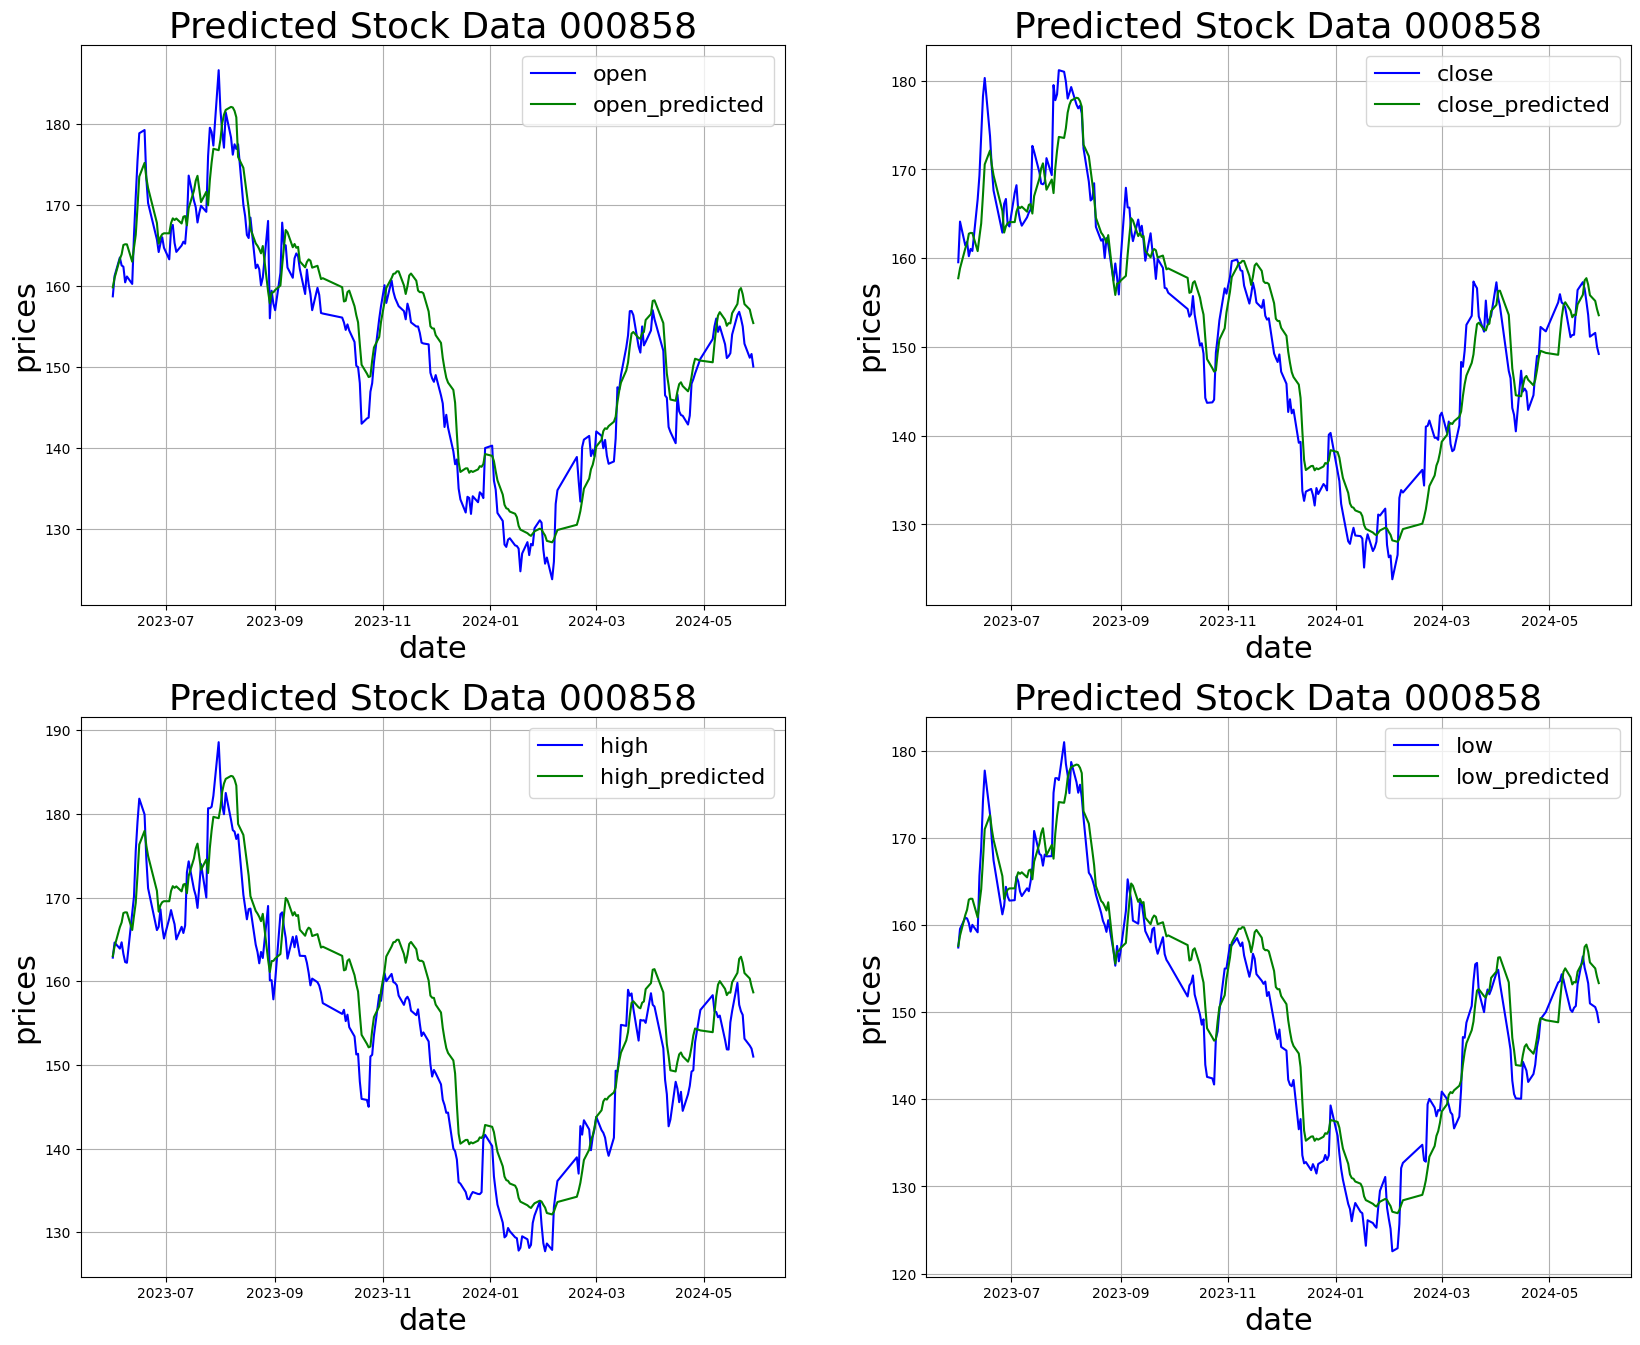

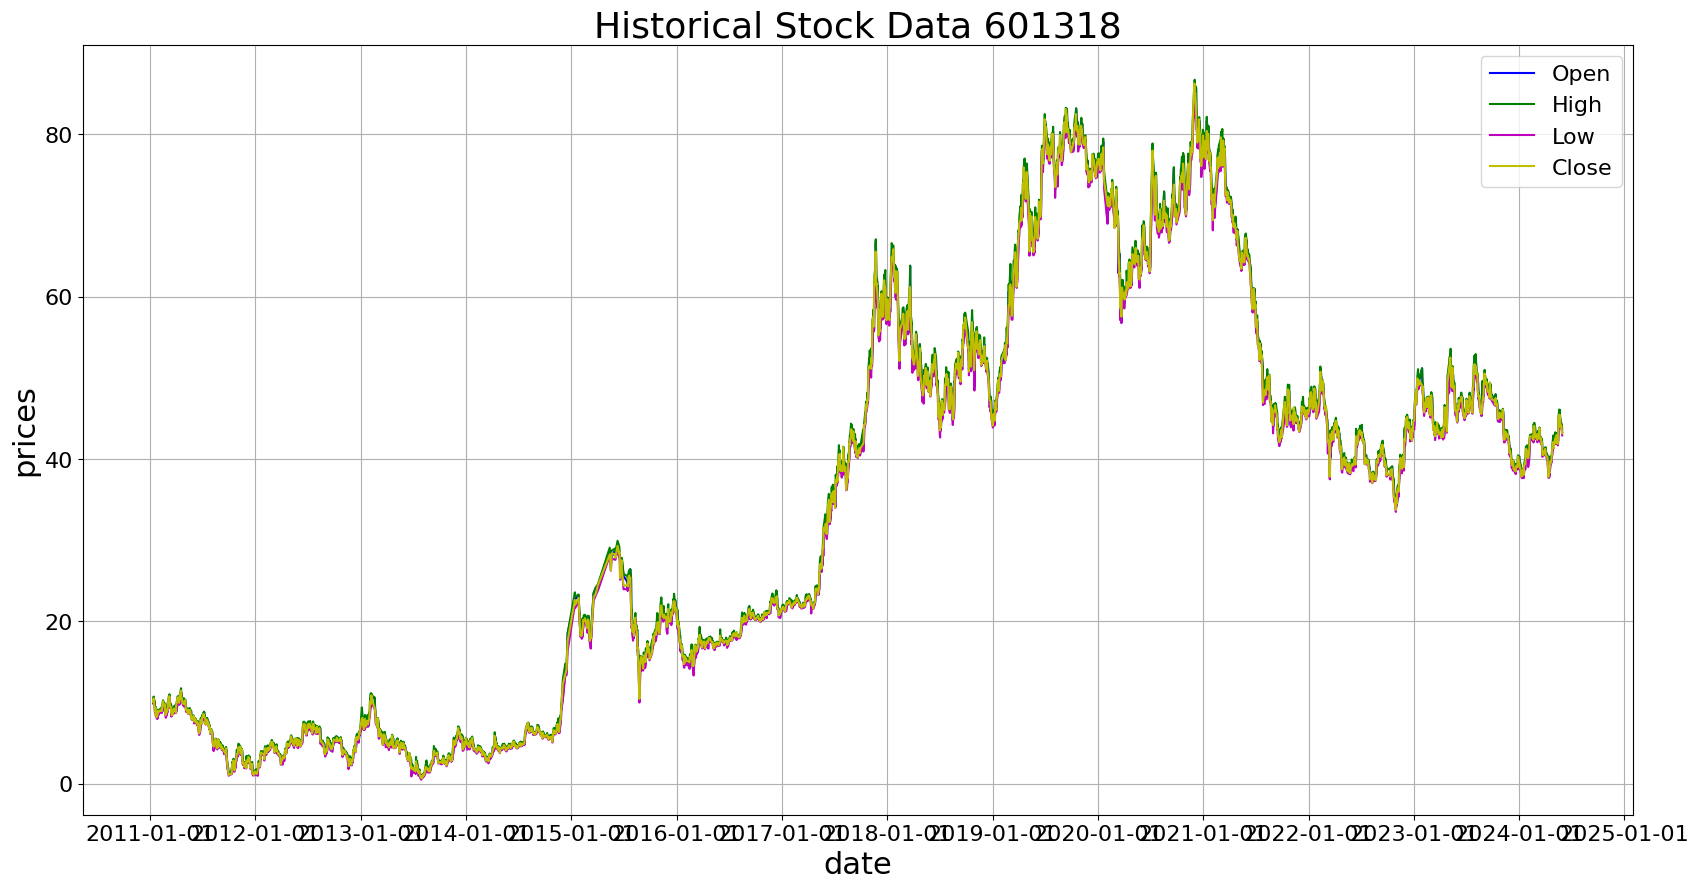

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 64)            24832     
                                                                 
 dropout_12 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_13 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_14 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_14 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_15 (LSTM)              (None, 128)              

Epoch 62/150
81/81 [==============================] - 1s 15ms/step - loss: 2.8790e-04 - val_loss: 1.4454e-04
Epoch 63/150
81/81 [==============================] - 1s 16ms/step - loss: 2.9853e-04 - val_loss: 1.6758e-04
Epoch 64/150
81/81 [==============================] - 1s 16ms/step - loss: 2.8966e-04 - val_loss: 4.0382e-04
Epoch 65/150
81/81 [==============================] - 1s 15ms/step - loss: 3.0783e-04 - val_loss: 1.0833e-04
Epoch 66/150
81/81 [==============================] - 1s 16ms/step - loss: 3.3985e-04 - val_loss: 1.1455e-04
Epoch 67/150
81/81 [==============================] - 1s 16ms/step - loss: 3.0290e-04 - val_loss: 1.3149e-04
Epoch 68/150
81/81 [==============================] - 1s 16ms/step - loss: 3.0526e-04 - val_loss: 1.1026e-04
Epoch 69/150
81/81 [==============================] - 1s 16ms/step - loss: 2.6400e-04 - val_loss: 9.7962e-05
Epoch 70/150
81/81 [==============================] - 1s 15ms/step - loss: 2.7162e-04 - val_loss: 1.4976e-04
Epoch 71/150
81/81 

Epoch 137/150
81/81 [==============================] - 1s 17ms/step - loss: 2.3103e-04 - val_loss: 1.0774e-04
Epoch 138/150
81/81 [==============================] - 1s 17ms/step - loss: 2.3678e-04 - val_loss: 1.1340e-04
Epoch 139/150
81/81 [==============================] - 1s 17ms/step - loss: 2.3869e-04 - val_loss: 1.0705e-04
Epoch 140/150
81/81 [==============================] - 1s 17ms/step - loss: 2.4600e-04 - val_loss: 1.0190e-04
Epoch 141/150
81/81 [==============================] - 1s 17ms/step - loss: 2.2470e-04 - val_loss: 1.1436e-04
Epoch 142/150
81/81 [==============================] - 1s 18ms/step - loss: 2.0662e-04 - val_loss: 1.4068e-04
Epoch 143/150
81/81 [==============================] - 1s 18ms/step - loss: 2.2622e-04 - val_loss: 1.3333e-04
Epoch 144/150
81/81 [==============================] - 1s 17ms/step - loss: 2.1663e-04 - val_loss: 2.4021e-04
Epoch 145/150
81/81 [==============================] - 1s 17ms/step - loss: 2.2312e-04 - val_loss: 1.1150e-04
Epoch 146/

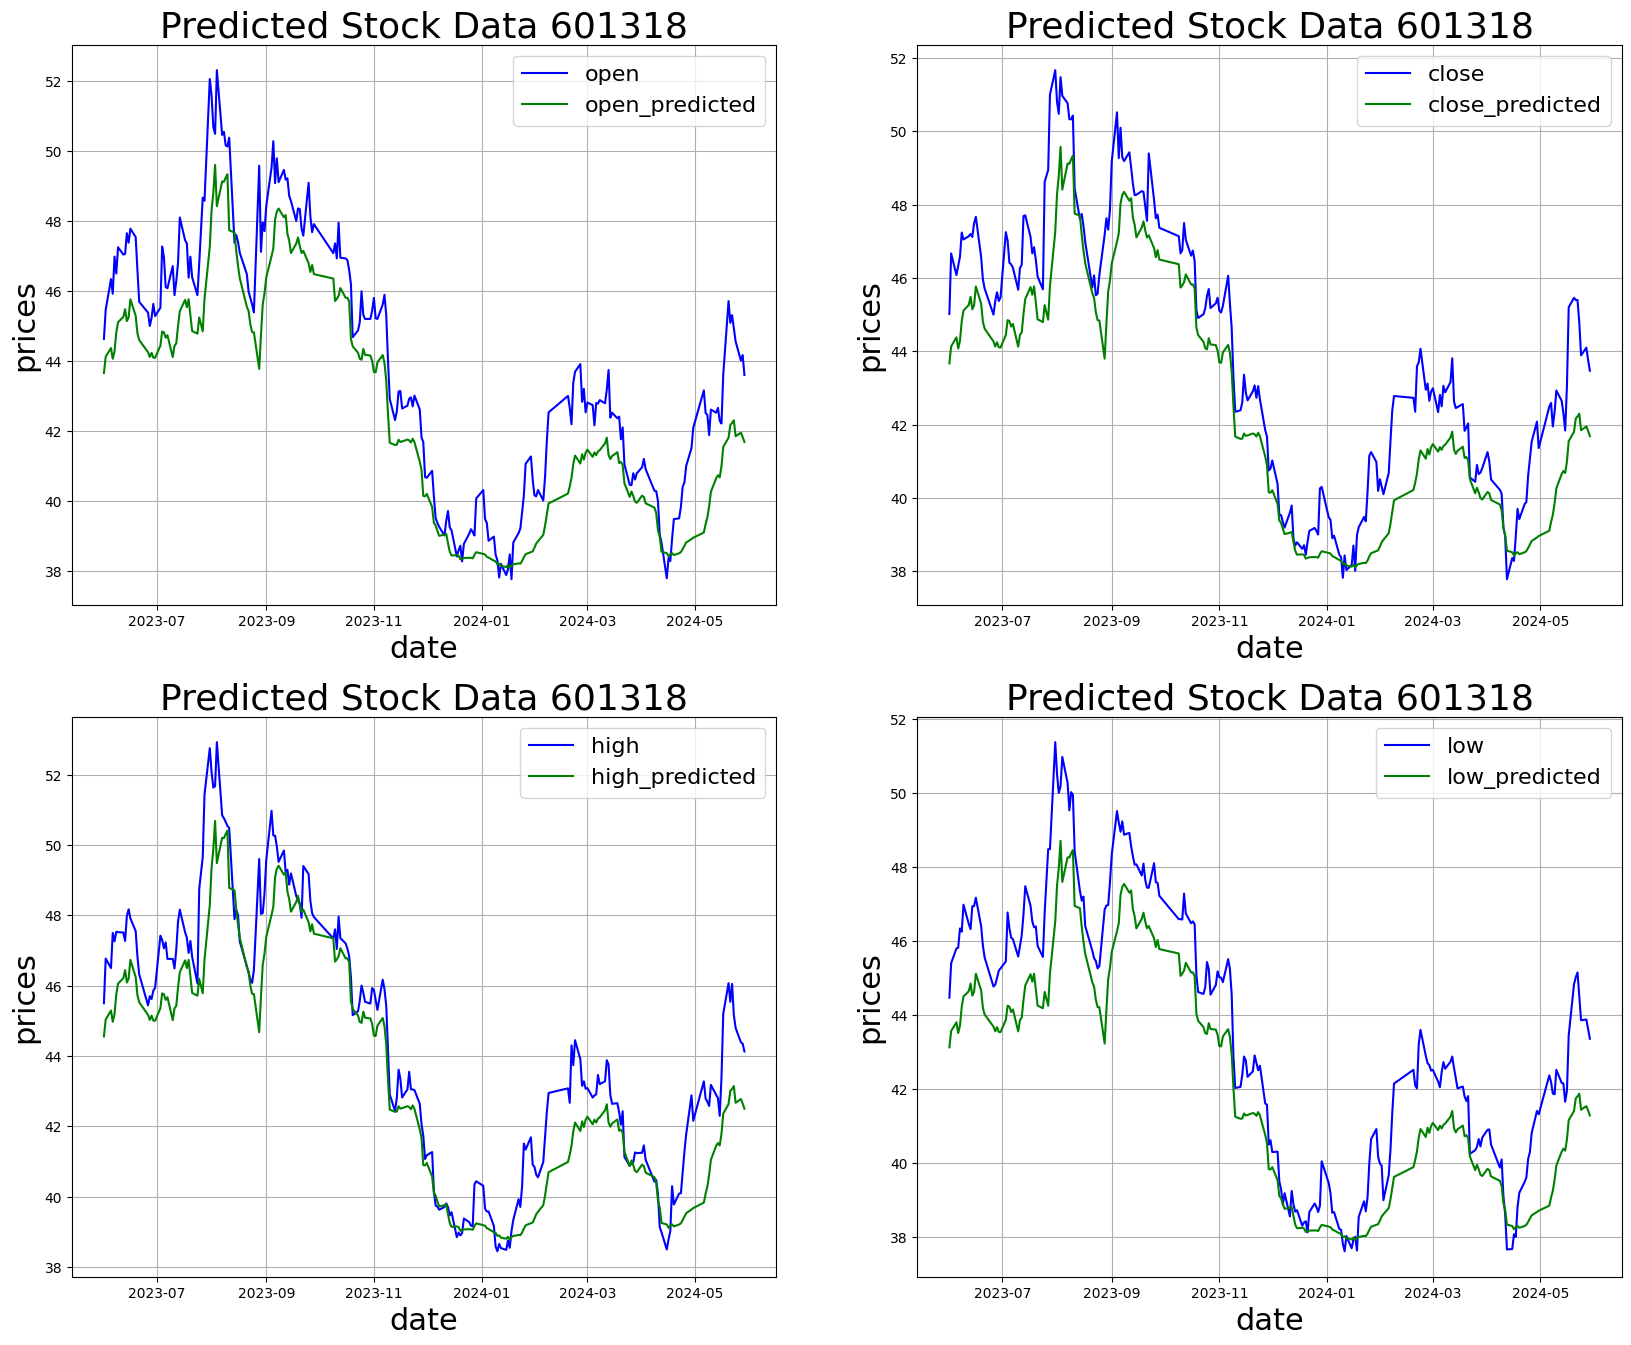

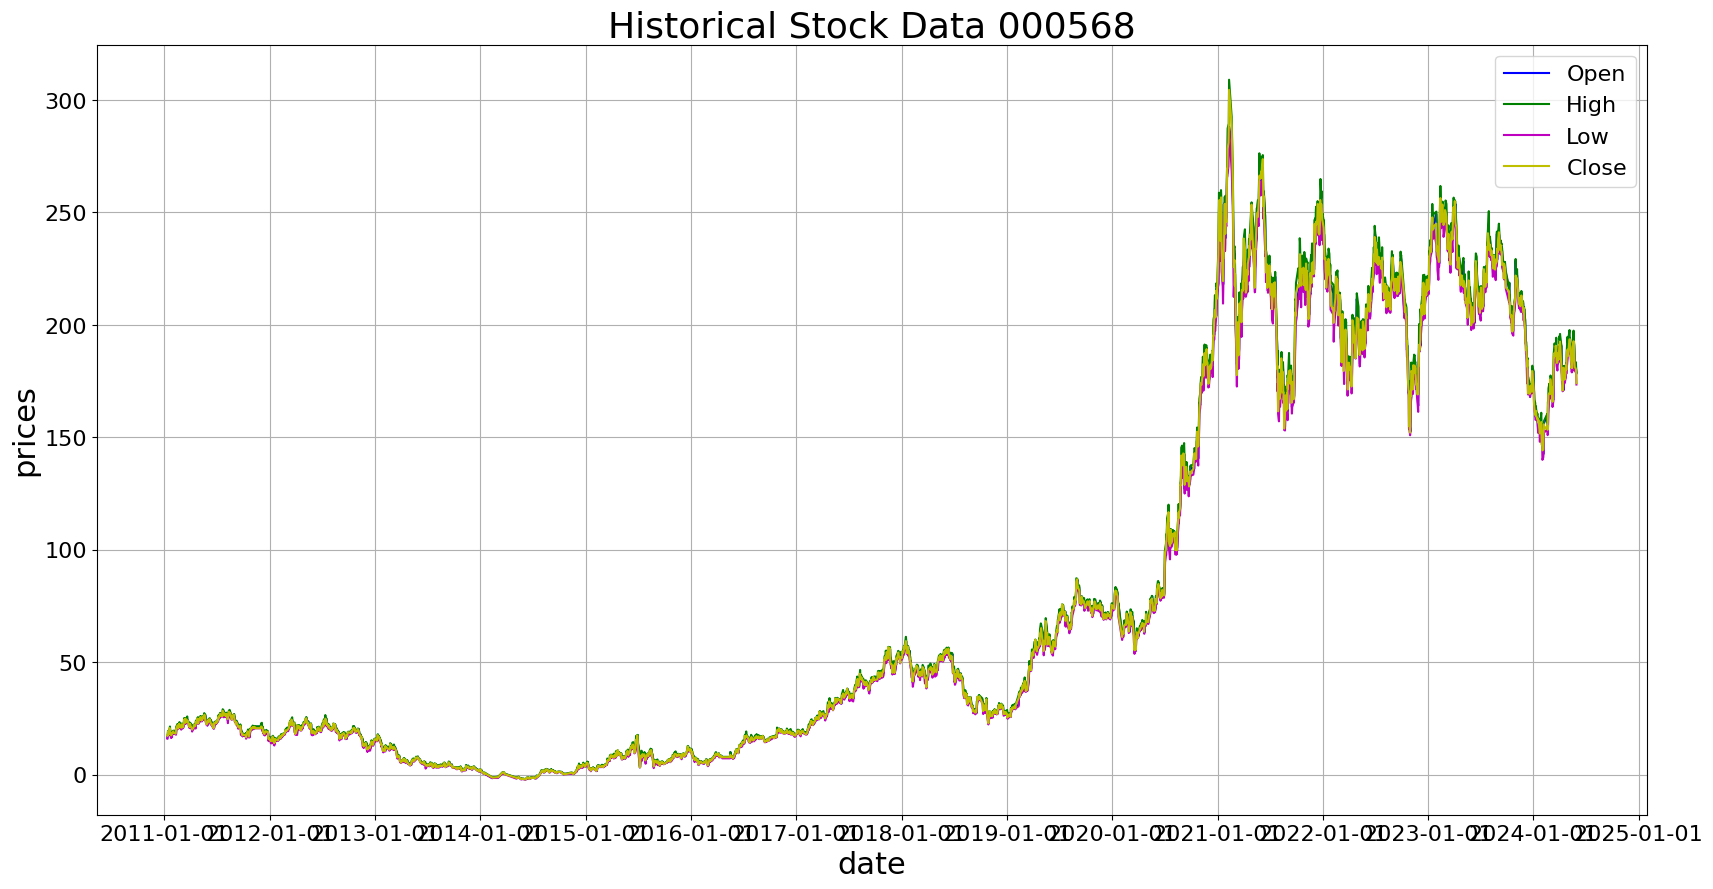

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 20, 64)            24832     
                                                                 
 dropout_16 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_17 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_17 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_18 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_18 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_19 (LSTM)              (None, 128)              

81/81 [==============================] - 1s 16ms/step - loss: 2.7669e-04 - val_loss: 6.9670e-04
Epoch 63/150
81/81 [==============================] - 1s 16ms/step - loss: 2.7877e-04 - val_loss: 7.8850e-04
Epoch 64/150
81/81 [==============================] - 1s 15ms/step - loss: 2.4728e-04 - val_loss: 4.1204e-04
Epoch 65/150
81/81 [==============================] - 1s 16ms/step - loss: 2.3068e-04 - val_loss: 4.4537e-04
Epoch 66/150
81/81 [==============================] - 1s 16ms/step - loss: 2.3850e-04 - val_loss: 4.2228e-04
Epoch 67/150
81/81 [==============================] - 1s 16ms/step - loss: 2.5087e-04 - val_loss: 4.1531e-04
Epoch 68/150
81/81 [==============================] - 1s 16ms/step - loss: 2.2683e-04 - val_loss: 4.6323e-04
Epoch 69/150
81/81 [==============================] - 1s 16ms/step - loss: 2.3712e-04 - val_loss: 4.6082e-04
Epoch 70/150
81/81 [==============================] - 1s 16ms/step - loss: 2.1564e-04 - val_loss: 4.0936e-04
Epoch 71/150
81/81 [============

81/81 [==============================] - 1s 16ms/step - loss: 2.1377e-04 - val_loss: 4.3744e-04
Epoch 138/150
81/81 [==============================] - 1s 16ms/step - loss: 1.7674e-04 - val_loss: 5.8148e-04
Epoch 139/150
81/81 [==============================] - 1s 17ms/step - loss: 1.8293e-04 - val_loss: 4.2627e-04
Epoch 140/150
81/81 [==============================] - 1s 17ms/step - loss: 1.6960e-04 - val_loss: 3.9395e-04
Epoch 141/150
81/81 [==============================] - 1s 16ms/step - loss: 1.9744e-04 - val_loss: 6.3456e-04
Epoch 142/150
81/81 [==============================] - 1s 16ms/step - loss: 2.1326e-04 - val_loss: 4.1049e-04
Epoch 143/150
81/81 [==============================] - 1s 16ms/step - loss: 1.7963e-04 - val_loss: 4.0677e-04
Epoch 144/150
81/81 [==============================] - 2s 19ms/step - loss: 1.7580e-04 - val_loss: 4.2554e-04
Epoch 145/150
81/81 [==============================] - 1s 17ms/step - loss: 1.5692e-04 - val_loss: 4.7743e-04
Epoch 146/150
81/81 [===

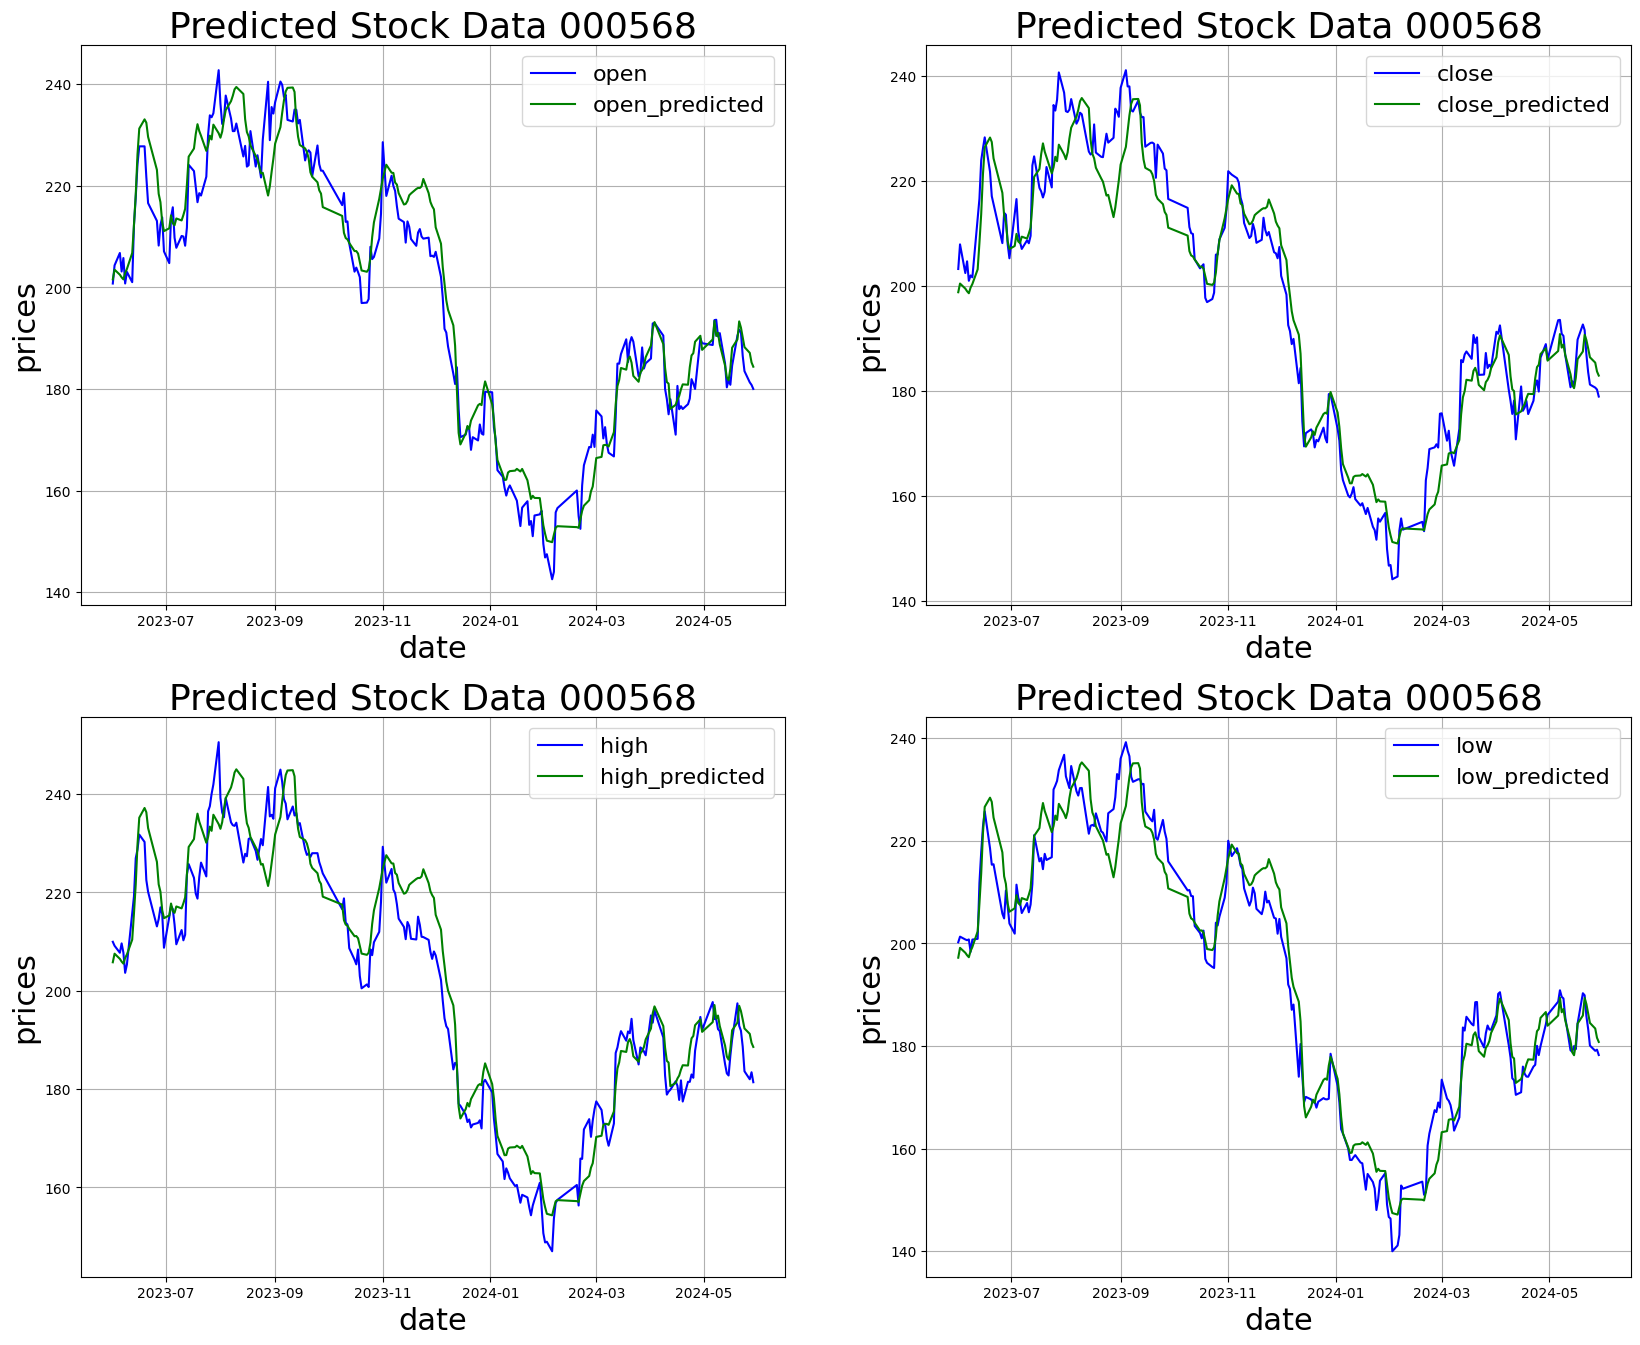

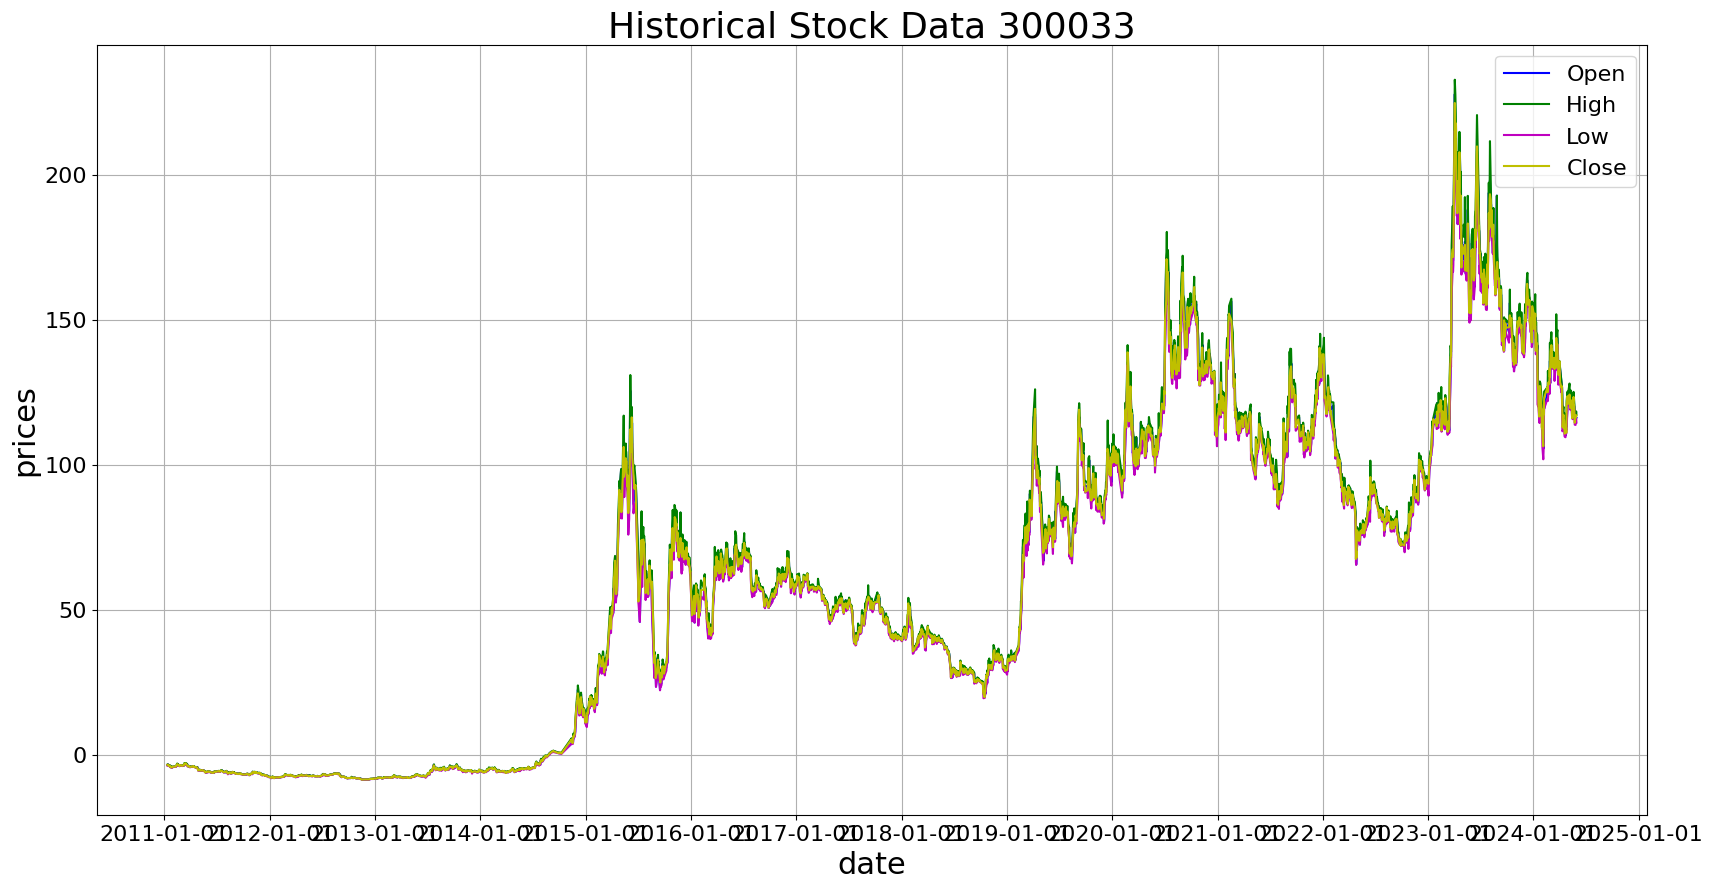

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 20, 64)            24832     
                                                                 
 dropout_20 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_21 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_21 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_22 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_22 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_23 (LSTM)              (None, 128)              

80/80 [==============================] - 1s 16ms/step - loss: 2.7922e-04 - val_loss: 9.1945e-04
Epoch 64/150
80/80 [==============================] - 1s 16ms/step - loss: 2.7902e-04 - val_loss: 9.2535e-04
Epoch 65/150
80/80 [==============================] - 1s 15ms/step - loss: 2.9223e-04 - val_loss: 8.2573e-04
Epoch 66/150
80/80 [==============================] - 1s 16ms/step - loss: 2.7068e-04 - val_loss: 7.7937e-04
Epoch 67/150
80/80 [==============================] - 1s 17ms/step - loss: 2.6861e-04 - val_loss: 9.1431e-04
Epoch 68/150
80/80 [==============================] - 1s 16ms/step - loss: 3.1884e-04 - val_loss: 8.9672e-04
Epoch 69/150
80/80 [==============================] - 2s 19ms/step - loss: 2.7799e-04 - val_loss: 0.0010
Epoch 70/150
80/80 [==============================] - 1s 17ms/step - loss: 2.7416e-04 - val_loss: 9.3784e-04
Epoch 71/150
80/80 [==============================] - 1s 17ms/step - loss: 2.7843e-04 - val_loss: 9.6382e-04
Epoch 72/150
80/80 [================

80/80 [==============================] - 1s 15ms/step - loss: 2.4226e-04 - val_loss: 6.4696e-04
Epoch 139/150
80/80 [==============================] - 1s 15ms/step - loss: 2.2408e-04 - val_loss: 6.8783e-04
Epoch 140/150
80/80 [==============================] - 1s 15ms/step - loss: 2.3671e-04 - val_loss: 6.9448e-04
Epoch 141/150
80/80 [==============================] - 1s 14ms/step - loss: 2.2822e-04 - val_loss: 0.0010
Epoch 142/150
80/80 [==============================] - 1s 15ms/step - loss: 2.1951e-04 - val_loss: 0.0014
Epoch 143/150
80/80 [==============================] - 1s 15ms/step - loss: 2.0221e-04 - val_loss: 8.1300e-04
Epoch 144/150
80/80 [==============================] - 1s 16ms/step - loss: 2.1289e-04 - val_loss: 9.6031e-04
Epoch 145/150
80/80 [==============================] - 1s 15ms/step - loss: 2.1193e-04 - val_loss: 9.4686e-04
Epoch 146/150
80/80 [==============================] - 1s 15ms/step - loss: 2.0360e-04 - val_loss: 7.3464e-04
Epoch 147/150
80/80 [===========

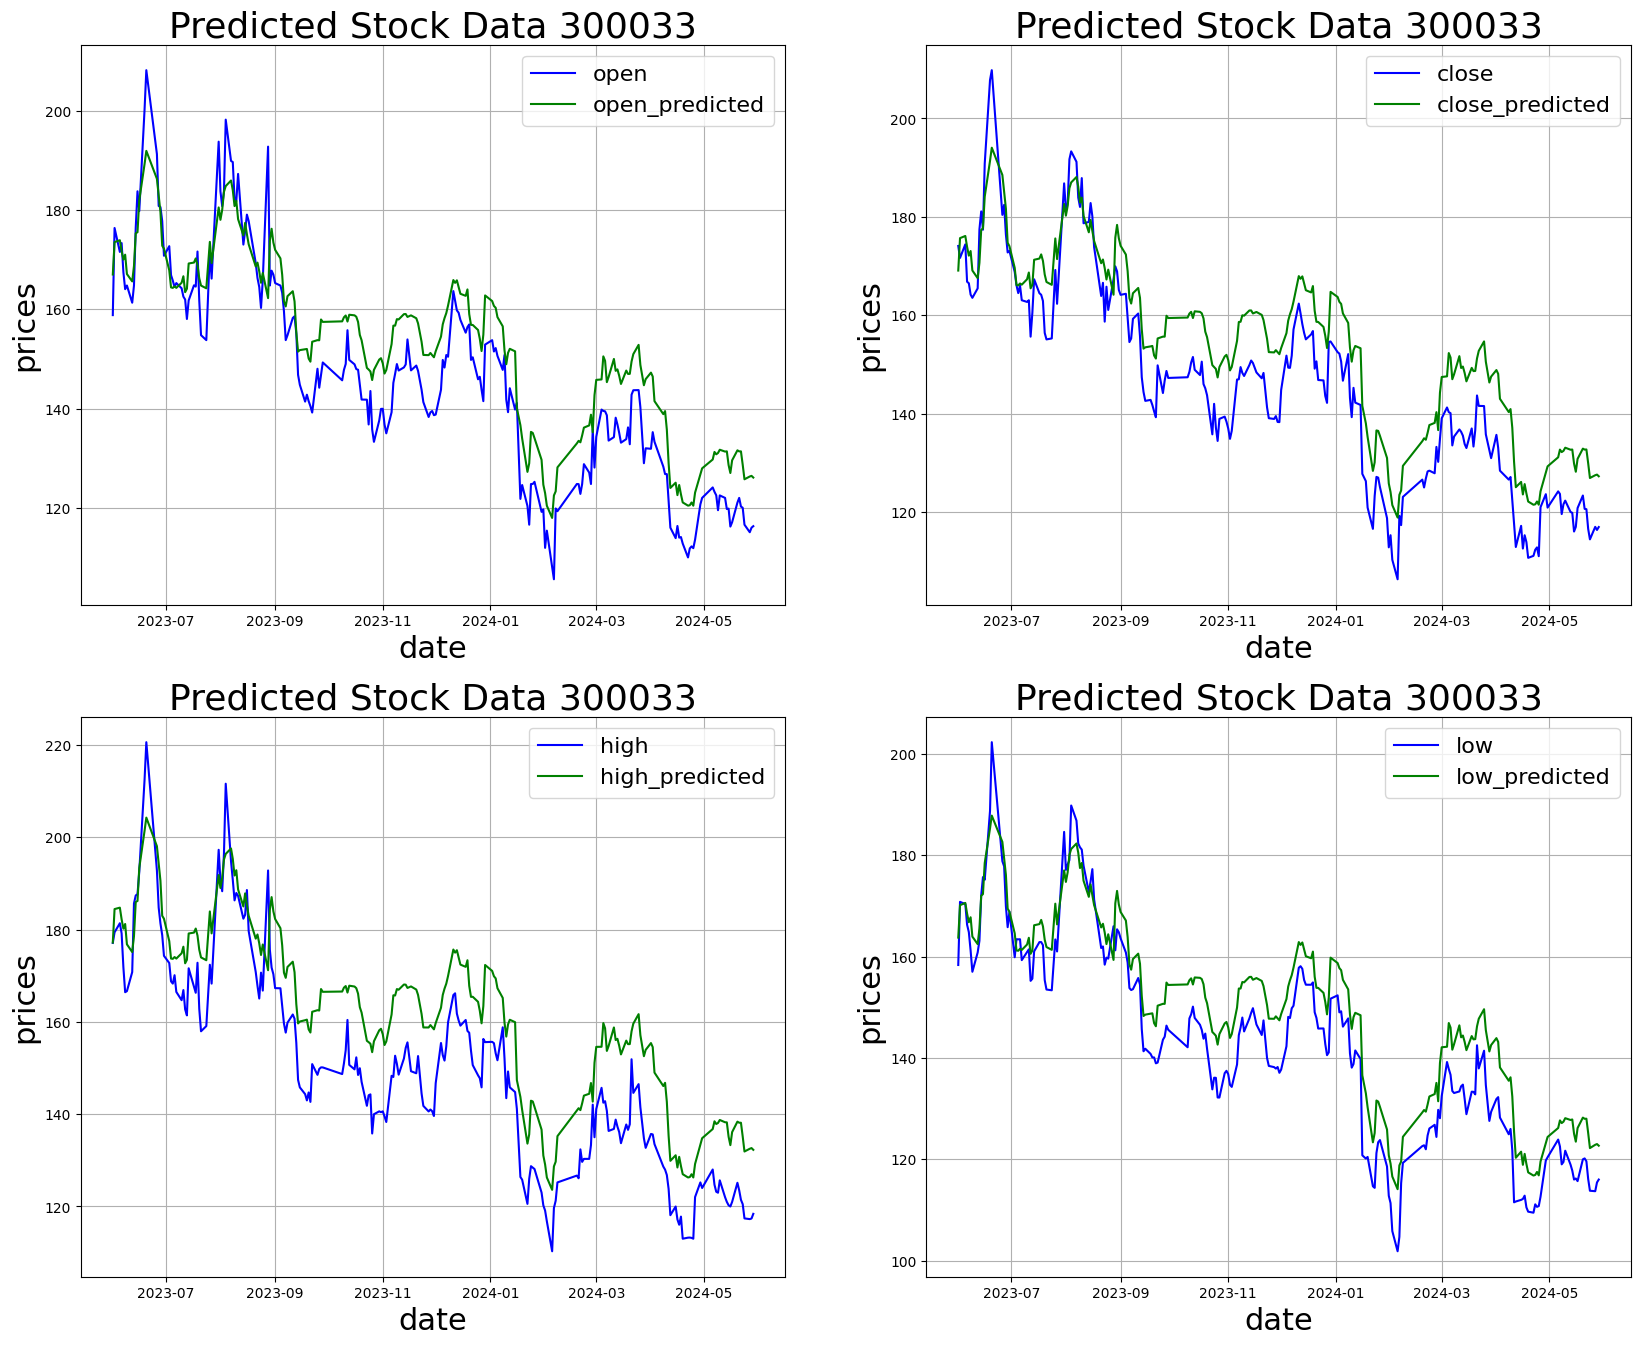

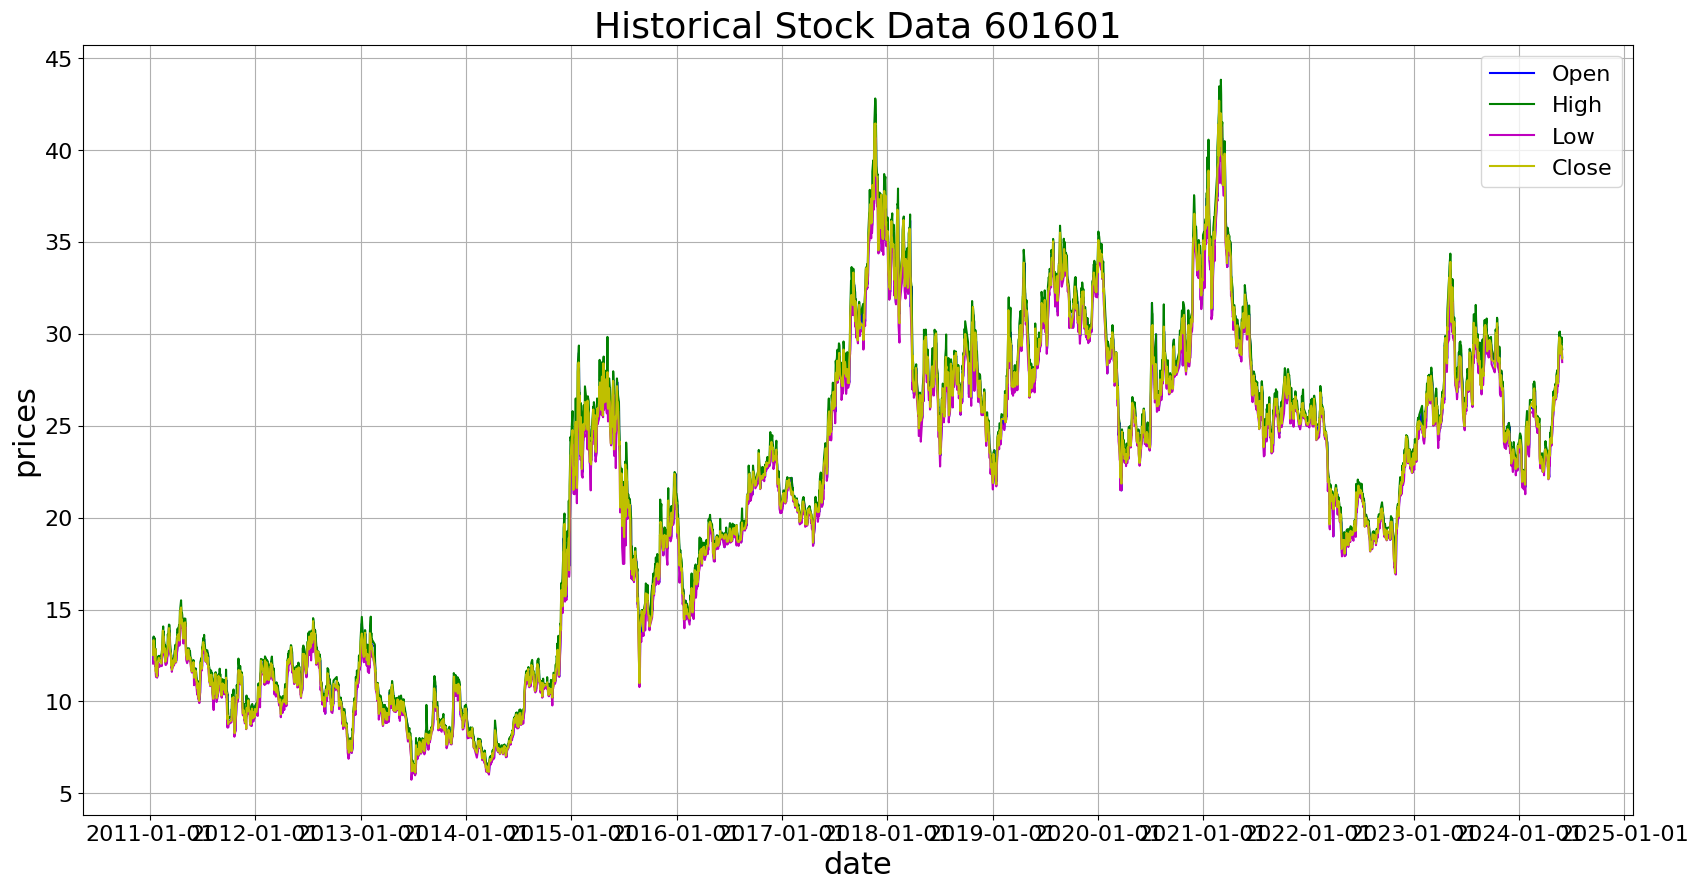

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 20, 64)            24832     
                                                                 
 dropout_24 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_25 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_25 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_26 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_26 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_27 (LSTM)              (None, 128)              

Epoch 62/150
84/84 [==============================] - 1s 16ms/step - loss: 3.9986e-04 - val_loss: 1.8569e-04
Epoch 63/150
84/84 [==============================] - 1s 16ms/step - loss: 3.6292e-04 - val_loss: 2.4098e-04
Epoch 64/150
84/84 [==============================] - 1s 16ms/step - loss: 3.7042e-04 - val_loss: 2.4887e-04
Epoch 65/150
84/84 [==============================] - 1s 17ms/step - loss: 4.1871e-04 - val_loss: 2.0295e-04
Epoch 66/150
84/84 [==============================] - 1s 16ms/step - loss: 3.8437e-04 - val_loss: 1.4572e-04
Epoch 67/150
84/84 [==============================] - 1s 15ms/step - loss: 3.6030e-04 - val_loss: 1.8952e-04
Epoch 68/150
84/84 [==============================] - 1s 16ms/step - loss: 3.4670e-04 - val_loss: 1.4742e-04
Epoch 69/150
84/84 [==============================] - 1s 16ms/step - loss: 3.9919e-04 - val_loss: 2.6075e-04
Epoch 70/150
84/84 [==============================] - 1s 16ms/step - loss: 3.8832e-04 - val_loss: 2.2902e-04
Epoch 71/150
84/84 

Epoch 137/150
84/84 [==============================] - 1s 15ms/step - loss: 3.3179e-04 - val_loss: 1.6091e-04
Epoch 138/150
84/84 [==============================] - 1s 15ms/step - loss: 3.1703e-04 - val_loss: 1.6329e-04
Epoch 139/150
84/84 [==============================] - 1s 16ms/step - loss: 3.3667e-04 - val_loss: 1.6259e-04
Epoch 140/150
84/84 [==============================] - 1s 16ms/step - loss: 3.3517e-04 - val_loss: 1.5357e-04
Epoch 141/150
84/84 [==============================] - 1s 15ms/step - loss: 3.3143e-04 - val_loss: 2.3303e-04
Epoch 142/150
84/84 [==============================] - 1s 16ms/step - loss: 3.2398e-04 - val_loss: 1.7348e-04
Epoch 143/150
84/84 [==============================] - 1s 15ms/step - loss: 3.6521e-04 - val_loss: 2.9376e-04
Epoch 144/150
84/84 [==============================] - 1s 16ms/step - loss: 3.2730e-04 - val_loss: 1.9425e-04
Epoch 145/150
84/84 [==============================] - 1s 15ms/step - loss: 3.2800e-04 - val_loss: 1.7584e-04
Epoch 146/

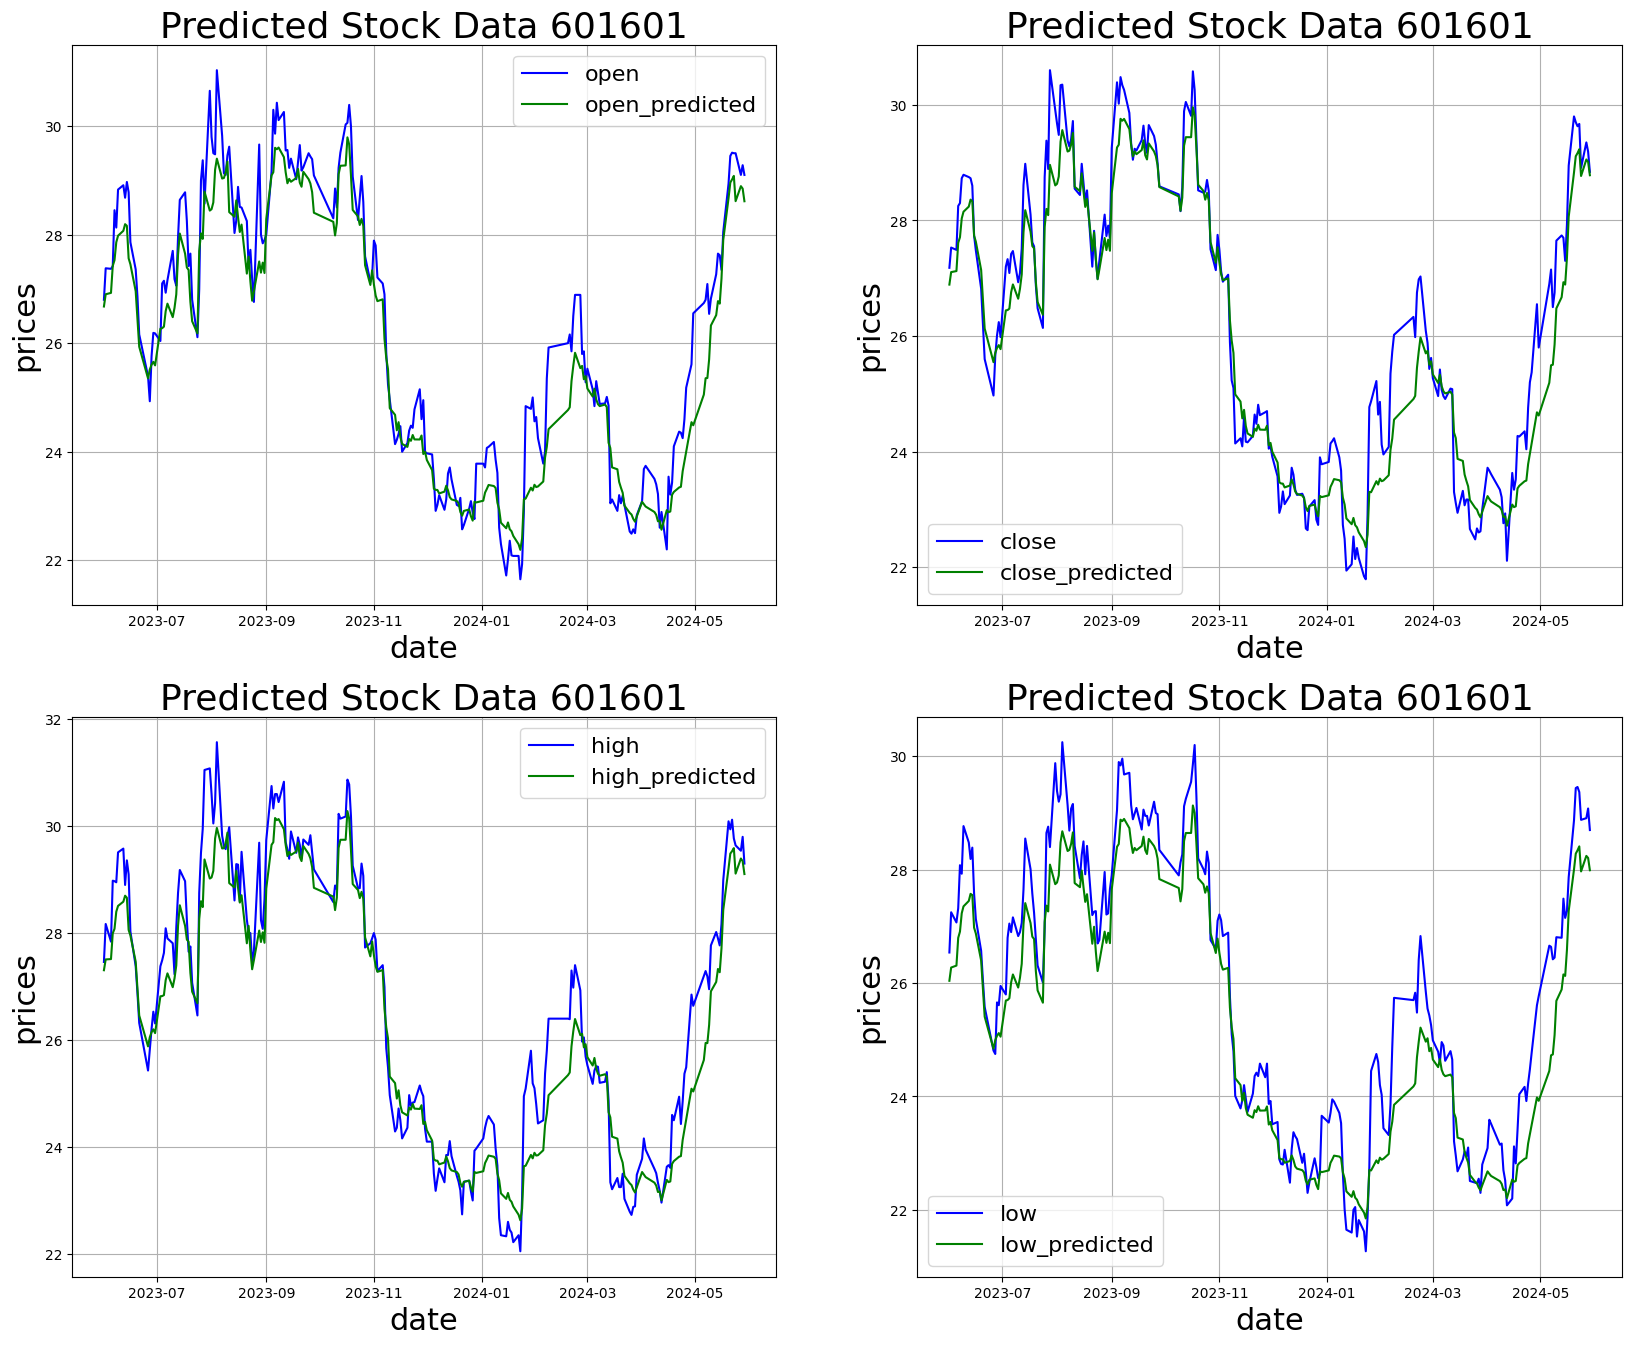

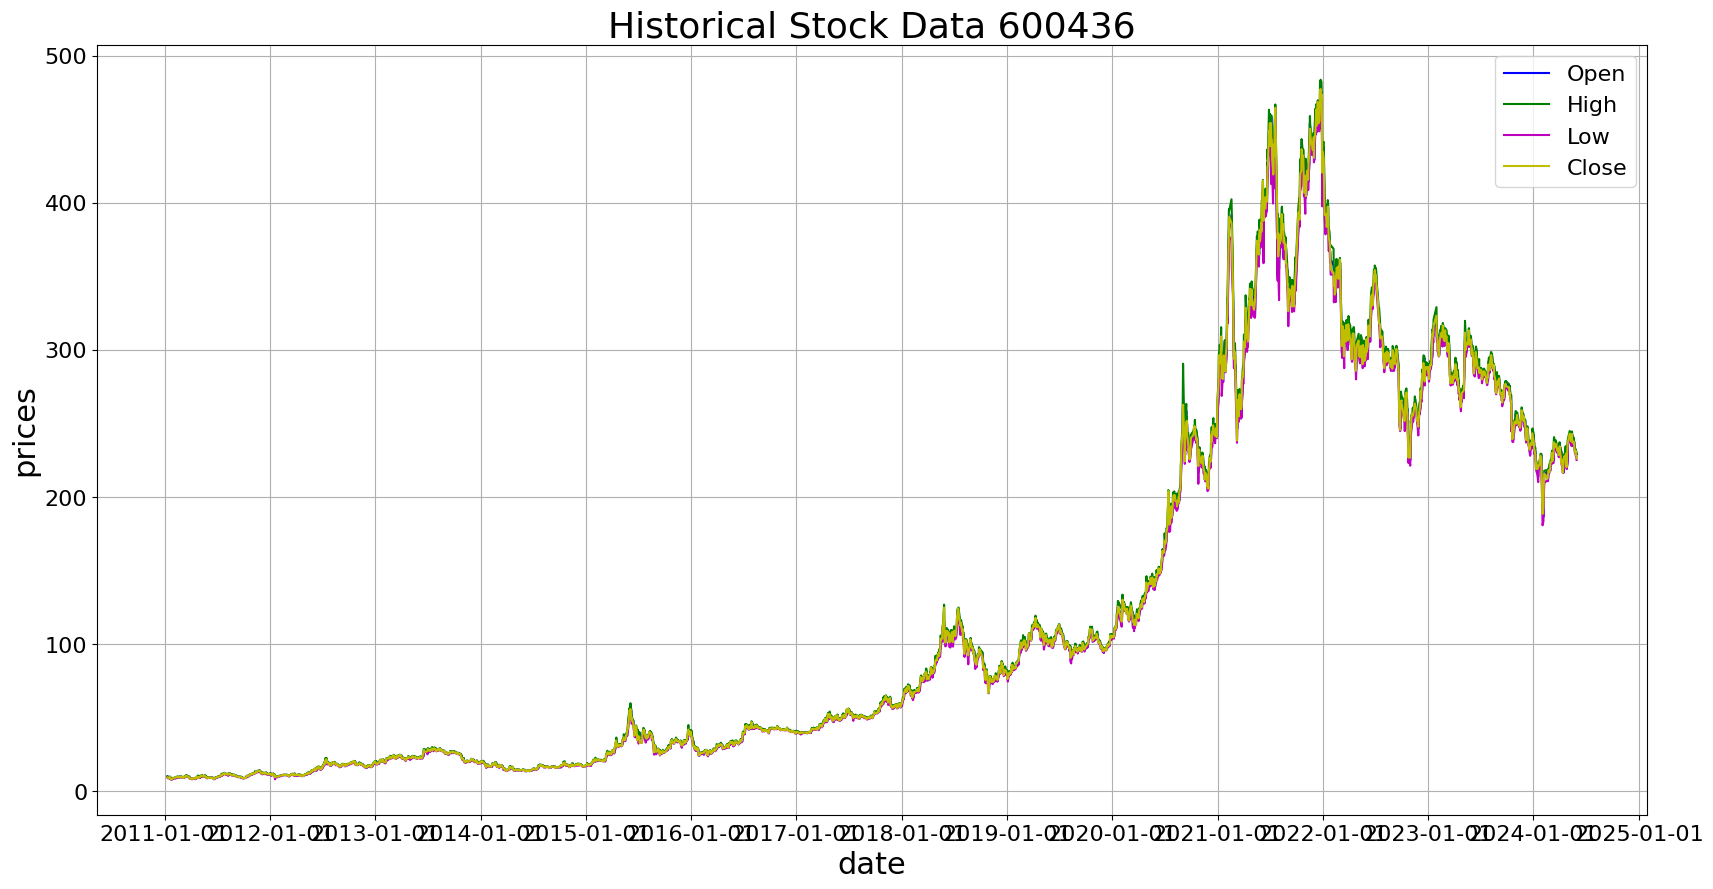

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 20, 64)            24832     
                                                                 
 dropout_28 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_29 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_29 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_30 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_30 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_31 (LSTM)              (None, 128)              

83/83 [==============================] - 1s 16ms/step - loss: 2.4114e-04 - val_loss: 8.0684e-04
Epoch 64/150
83/83 [==============================] - 1s 16ms/step - loss: 2.2424e-04 - val_loss: 3.4017e-04
Epoch 65/150
83/83 [==============================] - 1s 15ms/step - loss: 2.2583e-04 - val_loss: 3.6815e-04
Epoch 66/150
83/83 [==============================] - 1s 16ms/step - loss: 2.5093e-04 - val_loss: 3.9022e-04
Epoch 67/150
83/83 [==============================] - 1s 18ms/step - loss: 2.3416e-04 - val_loss: 3.9632e-04
Epoch 68/150
83/83 [==============================] - 1s 17ms/step - loss: 2.2012e-04 - val_loss: 3.2403e-04
Epoch 69/150
83/83 [==============================] - 1s 16ms/step - loss: 2.5777e-04 - val_loss: 0.0018
Epoch 70/150
83/83 [==============================] - 1s 16ms/step - loss: 2.3986e-04 - val_loss: 3.1307e-04
Epoch 71/150
83/83 [==============================] - 1s 16ms/step - loss: 2.0555e-04 - val_loss: 7.5225e-04
Epoch 72/150
83/83 [================

83/83 [==============================] - 1s 15ms/step - loss: 1.6364e-04 - val_loss: 0.0010
Epoch 139/150
83/83 [==============================] - 1s 15ms/step - loss: 1.6523e-04 - val_loss: 3.0979e-04
Epoch 140/150
83/83 [==============================] - 1s 15ms/step - loss: 1.8037e-04 - val_loss: 5.3417e-04
Epoch 141/150
83/83 [==============================] - 1s 16ms/step - loss: 1.8525e-04 - val_loss: 4.3987e-04
Epoch 142/150
83/83 [==============================] - 1s 16ms/step - loss: 1.8666e-04 - val_loss: 0.0010
Epoch 143/150
83/83 [==============================] - 1s 15ms/step - loss: 1.6957e-04 - val_loss: 3.6857e-04
Epoch 144/150
83/83 [==============================] - 1s 15ms/step - loss: 1.7749e-04 - val_loss: 4.0030e-04
Epoch 145/150
83/83 [==============================] - 1s 16ms/step - loss: 3.1738e-04 - val_loss: 3.4785e-04
Epoch 146/150
83/83 [==============================] - 1s 16ms/step - loss: 2.1573e-04 - val_loss: 5.4761e-04
Epoch 147/150
83/83 [===========

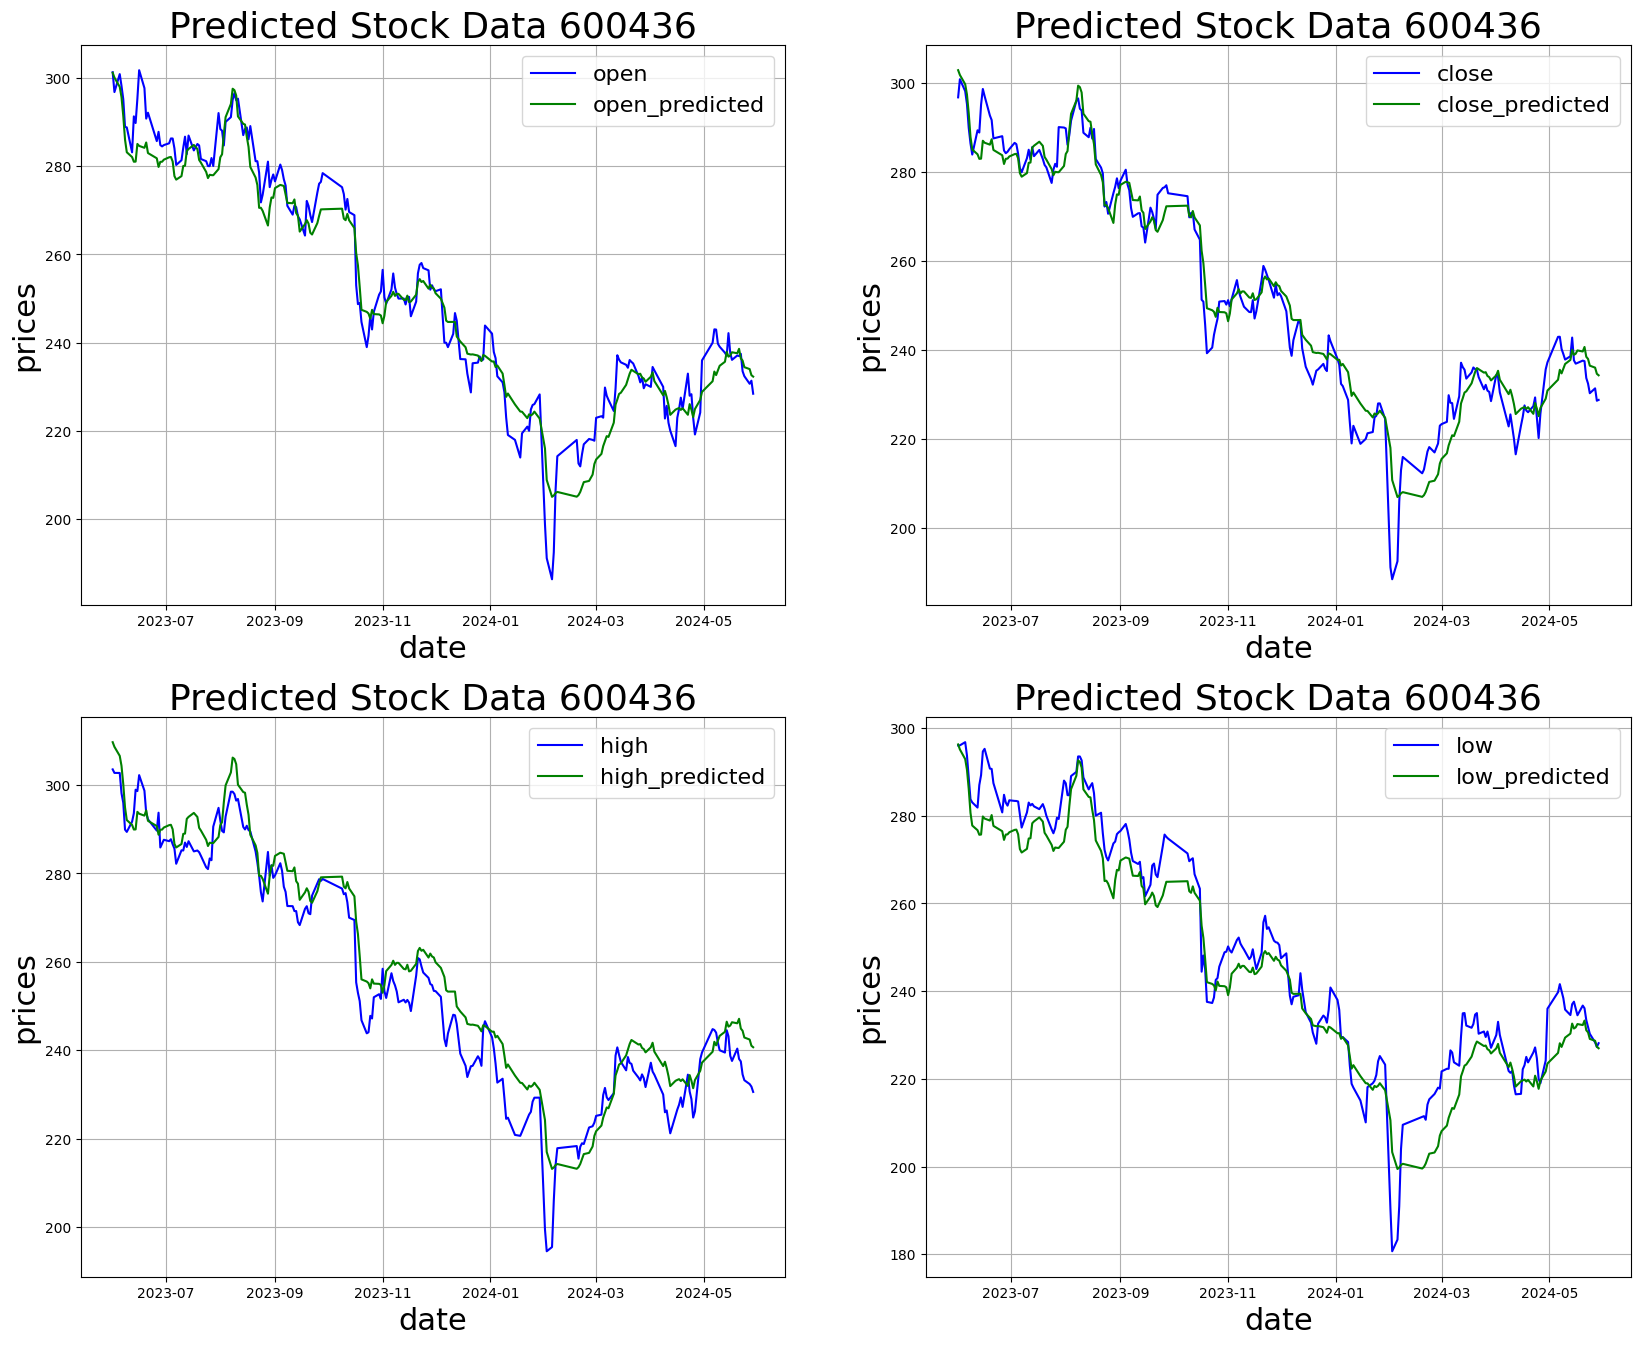

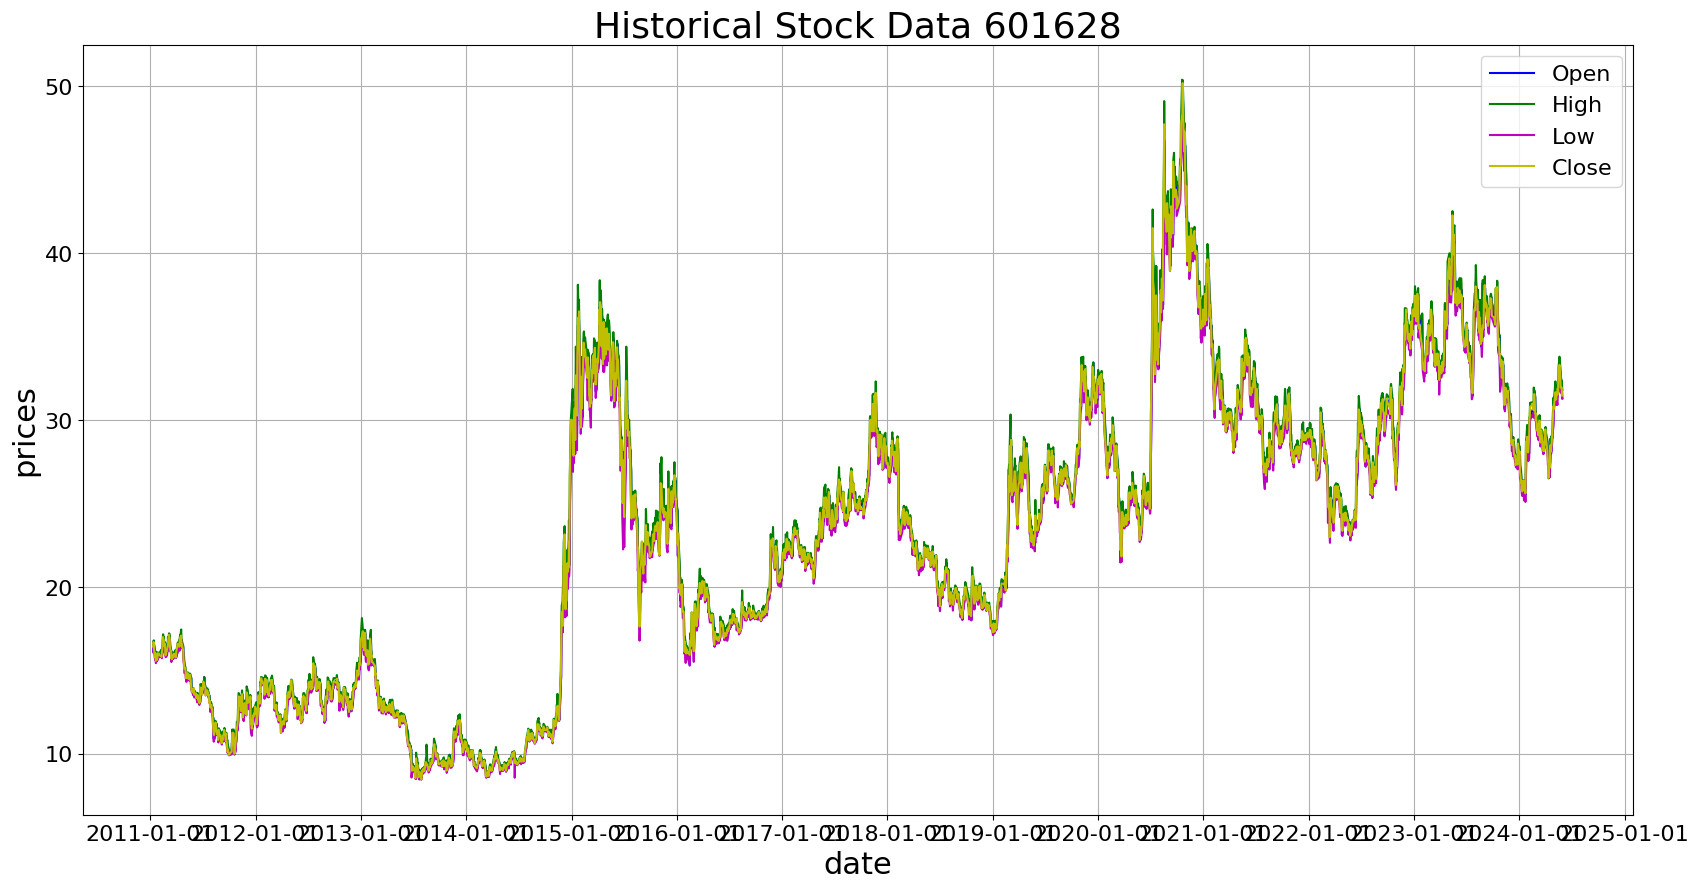

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 20, 64)            24832     
                                                                 
 dropout_32 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_33 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_33 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_34 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_34 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_35 (LSTM)              (None, 128)              

84/84 [==============================] - 1s 15ms/step - loss: 3.3785e-04 - val_loss: 6.3333e-04
Epoch 63/150
84/84 [==============================] - 1s 15ms/step - loss: 3.2541e-04 - val_loss: 2.6235e-04
Epoch 64/150
84/84 [==============================] - 1s 17ms/step - loss: 3.2629e-04 - val_loss: 1.9532e-04
Epoch 65/150
84/84 [==============================] - 1s 16ms/step - loss: 3.0465e-04 - val_loss: 1.7657e-04
Epoch 66/150
84/84 [==============================] - 1s 16ms/step - loss: 3.2474e-04 - val_loss: 1.9153e-04
Epoch 67/150
84/84 [==============================] - 1s 16ms/step - loss: 2.9409e-04 - val_loss: 2.0630e-04
Epoch 68/150
84/84 [==============================] - 1s 16ms/step - loss: 2.9979e-04 - val_loss: 2.6067e-04
Epoch 69/150
84/84 [==============================] - 1s 15ms/step - loss: 3.5594e-04 - val_loss: 6.4151e-04
Epoch 70/150
84/84 [==============================] - 1s 16ms/step - loss: 3.2864e-04 - val_loss: 2.8021e-04
Epoch 71/150
84/84 [============

Epoch 137/150
84/84 [==============================] - 1s 16ms/step - loss: 2.4261e-04 - val_loss: 2.4445e-04
Epoch 138/150
84/84 [==============================] - 1s 16ms/step - loss: 2.5442e-04 - val_loss: 5.4730e-04
Epoch 139/150
84/84 [==============================] - 1s 16ms/step - loss: 2.6785e-04 - val_loss: 1.9684e-04
Epoch 140/150
84/84 [==============================] - 1s 16ms/step - loss: 2.9486e-04 - val_loss: 2.9696e-04
Epoch 141/150
84/84 [==============================] - 1s 15ms/step - loss: 2.8817e-04 - val_loss: 2.0699e-04
Epoch 142/150
84/84 [==============================] - 1s 15ms/step - loss: 2.7927e-04 - val_loss: 2.1777e-04
Epoch 143/150
84/84 [==============================] - 1s 15ms/step - loss: 2.4632e-04 - val_loss: 2.4677e-04
Epoch 144/150
84/84 [==============================] - 1s 15ms/step - loss: 2.6714e-04 - val_loss: 2.5294e-04
Epoch 145/150
84/84 [==============================] - 1s 15ms/step - loss: 2.7870e-04 - val_loss: 2.1206e-04
Epoch 146/

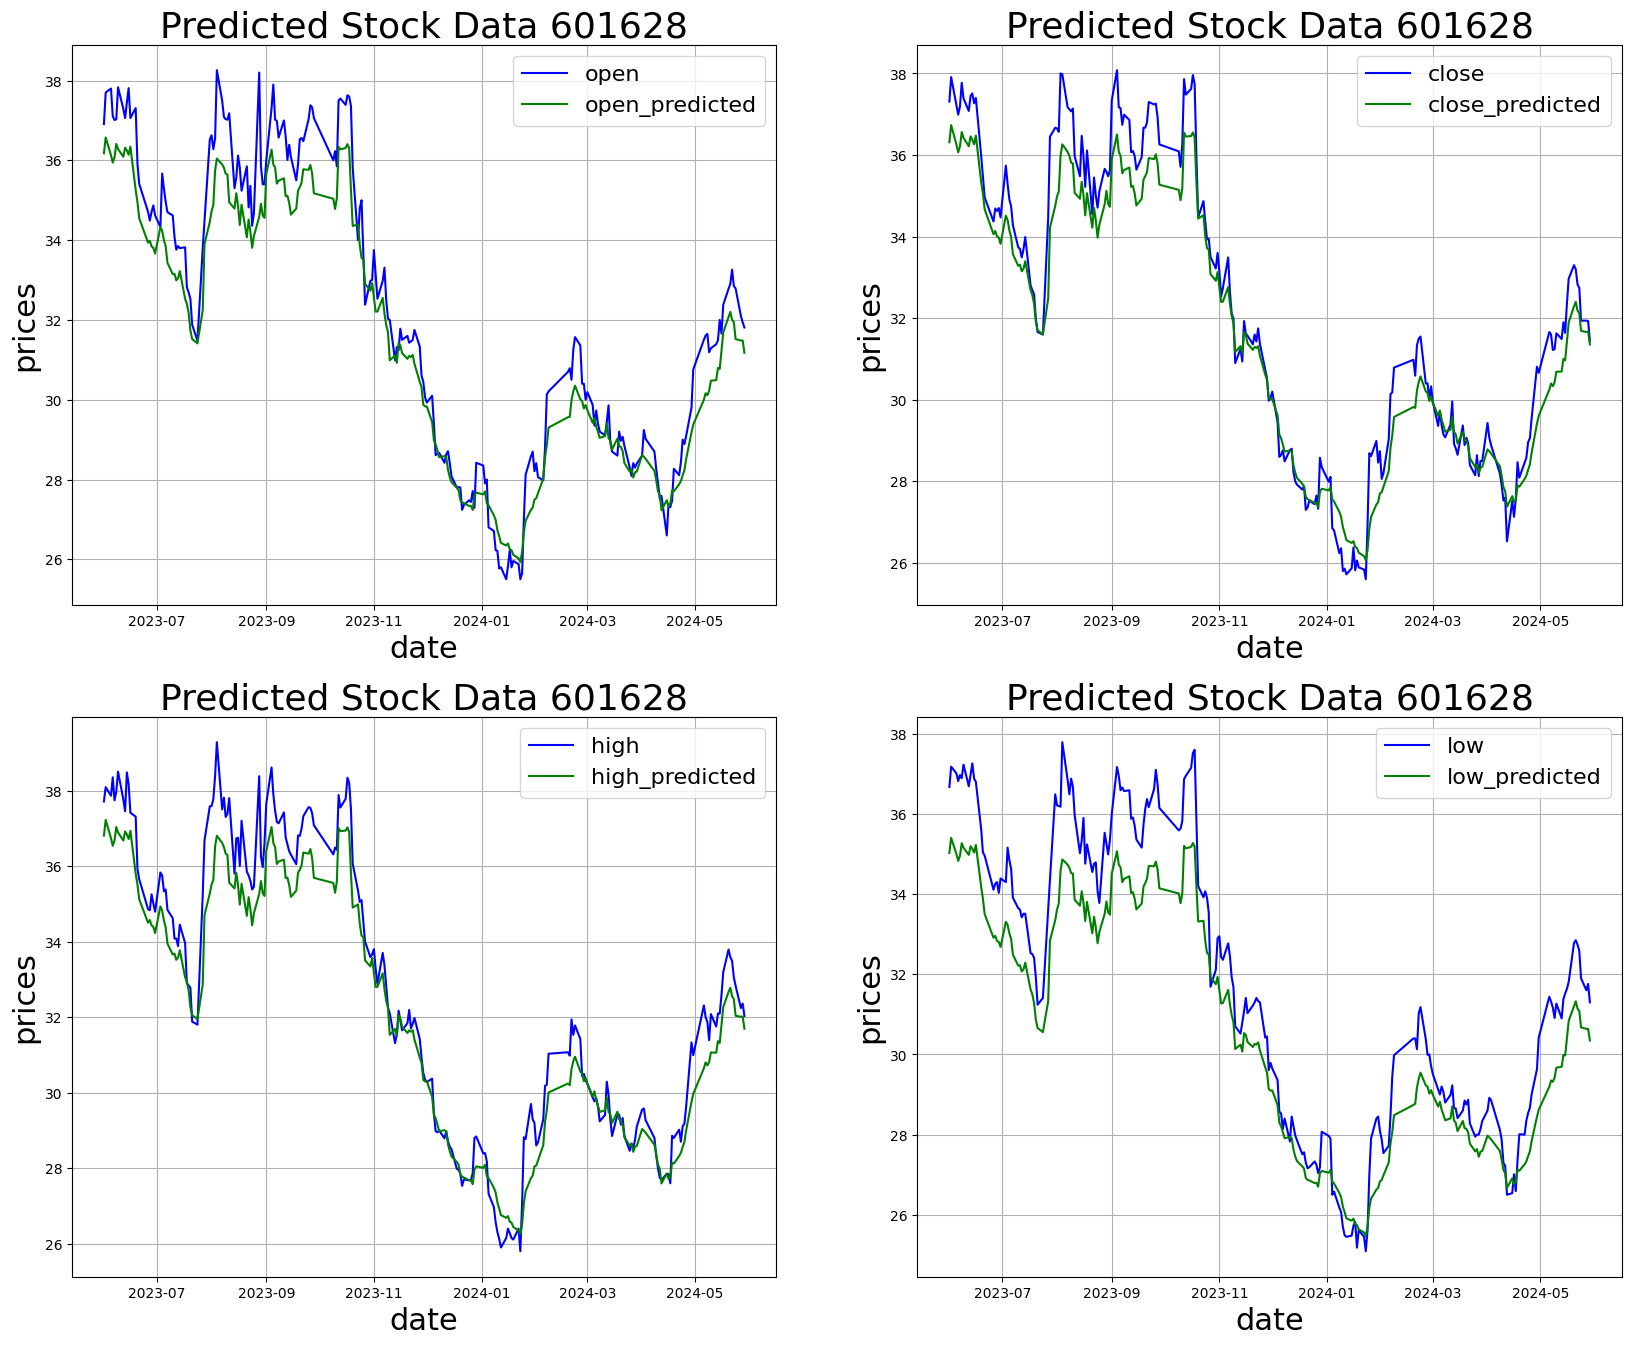

In [3]:
# 交易的股票：
share_list=['002304','600111','000858','601318','000568','300033','601601','600436','601628']

for code in share_list:
    main_script(code)